In [1]:
Эта полный код курсовой работы. Но поскольку он очень долгий я закомментил код исследования признаков в файле Credit_Score_HW

Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту) Это четвертый вид усреднения(не микро не макро) байнери.

Тетрадка Jupyter Notebook с кодом Вашего решения
Укажите свой ник на kaggle: altaypower

Описание датасета

Home Ownership - домовладение<br>
Annual Income - годовой доход<br>
Years in current job - количество лет на текущем месте работы<br>
Tax Liens - налоговые обременения<br>
Number of Open Accounts - количество открытых счетов<br>
Years of Credit History - количество лет кредитной истории<br>
Maximum Open Credit - наибольший открытый кредит<br>
Number of Credit Problems - количество проблем с кредитом<br>
Months since last delinquent - количество месяцев с последней просрочки платежа<br>
Bankruptcies - банкротства<br>
Purpose - цель кредита<br>
Term - срок кредита<br>
Current Loan Amount - текущая сумма кредита<br>
Current Credit Balance - текущий кредитный баланс<br>
Monthly Debt - ежемесячный долг<br>
Credit Score - баллы кредитного рейтинга<br>
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)<br>

Построение модели классификации

Обзор обучающего датасета<br>
Обработка выбросов<br>
Обработка пропусков<br>
Анализ данных<br>
Отбор признаков<br>
Балансировка классов<br>
Подбор моделей, получение бейзлана<br>
Выбор наилучшей модели, настройка гиперпараметров<br>
Проверка качества, борьба с переобучением<br>
Интерпретация результатов<br>
Прогнозирование на тестовом датасете<br>
<br>

Выполнить для тестового датасета те же этапы обработки и построения признаков<br>
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете<br>
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)<br>
Соблюдать исходный порядок примеров из тестового датасета

In [2]:
!pip3 install catboost

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import catboost as catb
from catboost import CatBoostRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from scipy.stats import shapiro
from scipy.stats import probplot # распределение на нормальность
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
from xgboost import XGBRegressor
from sklearn.datasets import make_regression

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def evaluate_preds_nan(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [10]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [12]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [13]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [14]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [15]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [16]:
#TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Classific/train.csv'
#TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Classific/test.csv'

**Загрузка данных**

In [17]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [18]:
df_train=df_train.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score', 'Credit Default': 'Credit_Default'})

In [19]:
df_train.head()

Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [20]:
df_train.shape

(7500, 17)

In [21]:
df_train['Credit_Default'].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                7500 non-null   object 
 1   Annual_Income                 5943 non-null   float64
 2   Years_in_current_job          7129 non-null   object 
 3   Tax_Liens                     7500 non-null   float64
 4   Number_of_Open_Accounts       7500 non-null   float64
 5   Years_of_Credit_History       7500 non-null   float64
 6   Maximum_Open_Credit           7500 non-null   float64
 7   Number_of_Credit_Problems     7500 non-null   float64
 8   Months_since_last_delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current_Loan_Amount           7500 non-null   float64
 13  Cur

In [23]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [24]:
df_test.shape

(2500, 16)

In [25]:
df_test=df_test.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score'})

In [26]:
df_test.head()

Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current_Loan_Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

## 1. **РАЗБОР ПЕРЕМЕННЫХ НА КАТЕГОРИИ**  <a class='anchor' id='eda'>

In [27]:
TARGET_NAME = 'Credit_Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

**Целевая переменная**

In [28]:
df_train['Credit_Default'].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

**Количественные переменные**

In [29]:
df_train.describe()

Annual_Income    Tax_Liens  Number_of_Open_Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years_of_Credit_History  Maximum_Open_Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current_Loan_Amount  Current_Credit_Balance   Monthly_Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit_Score  Credit_Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [30]:
df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

['Annual_Income',
 'Tax_Liens',
 'Number_of_Open_Accounts',
 'Years_of_Credit_History',
 'Maximum_Open_Credit',
 'Number_of_Credit_Problems',
 'Months_since_last_delinquent',
 'Bankruptcies',
 'Current_Loan_Amount',
 'Current_Credit_Balance',
 'Monthly_Debt',
 'Credit_Score',
 'Credit_Default']

**Номинативные переменные**

In [31]:
df_train.select_dtypes(include='object').columns.tolist()

['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

In [32]:
df_train.Home_Ownership.value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64

In [33]:
df_train.Years_in_current_job.value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64

In [34]:
df_train.Purpose.value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [35]:
df_train.Term.value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [36]:
NUM_FEATURE_NAMES = ['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
                    'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent',
                    'Bankruptcies', 'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score'
                    ]

CAT_FEATURE_NAMES = ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

## 2. **Похожесть теста и трейна**  <a class='anchor' id='eda'>

Визуализирую признаки на трейне и тесте.

Annual_Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


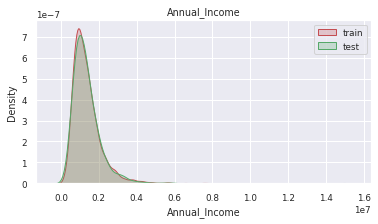

Tax_Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


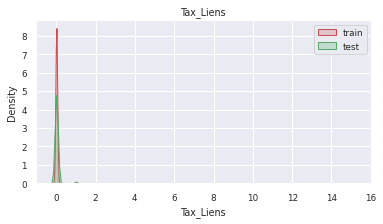

Number_of_Open_Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


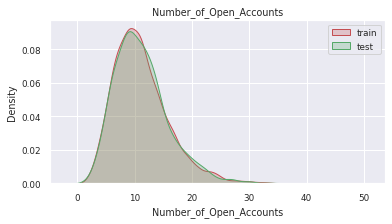

Years_of_Credit_History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


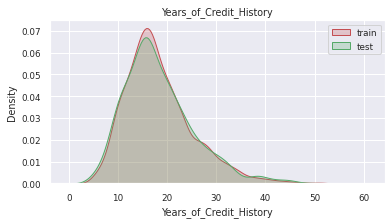

Maximum_Open_Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


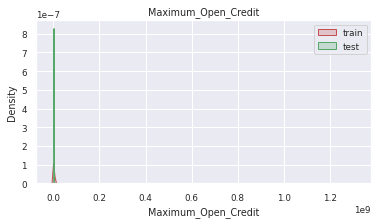

Number_of_Credit_Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


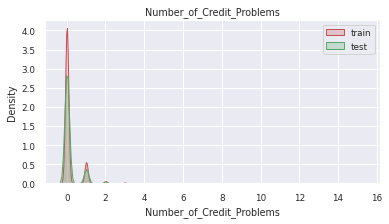

Months_since_last_delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


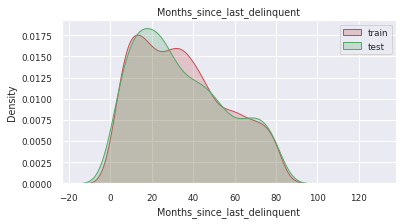

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


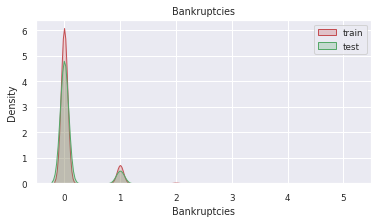

Current_Loan_Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


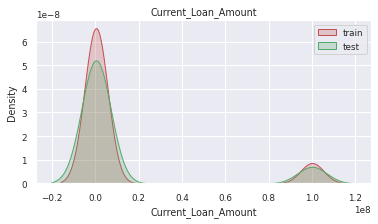

Current_Credit_Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


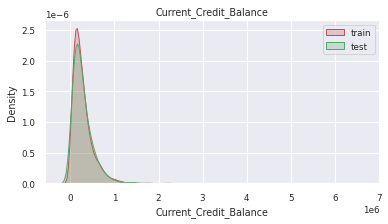

Monthly_Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


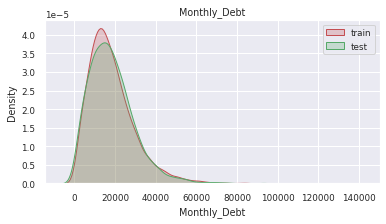

Credit_Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


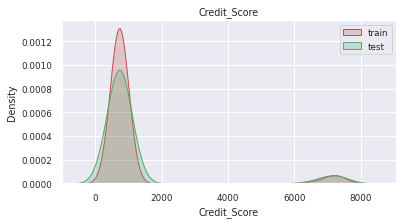

In [37]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

Методом Шапиро-Уилка проверяю на нормальность.Оценю эквивалентность мат. ожадиний трейна и теста, с помощью критерия Манна-Уитни и построю доверительные интервалы для средних значений, каждой из двух групп.

In [38]:
# Функция создания датафрейма для доверительных интервалов
def for_compare(X):
    For_compare = pd.DataFrame(df_train[X])
    For_compare['Is_train'] = 1
    For_compare2 = pd.DataFrame(df_test[X])
    For_compare2['Is_train'] = 0
    For_compare = pd.concat([For_compare, For_compare2], axis=0)

    return For_compare


In [39]:
df_train_med=df_train.fillna(value=df_train.median())

In [40]:
df_test_med=df_test.fillna(value=df_train.median())

**Annual_Income**

In [41]:
mannwhitneyu(df_train['Annual_Income'], df_test['Annual_Income'])

MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)

In [42]:
Annual_Income_for_compare = for_compare('Annual_Income')

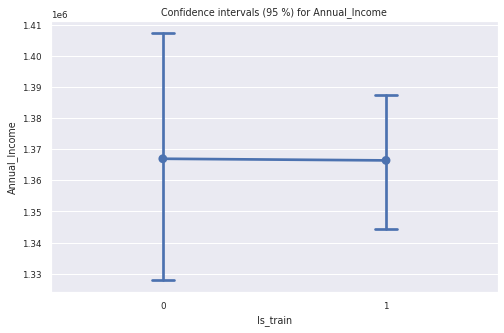

In [43]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Annual_Income', data=Annual_Income_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual_Income')
plt.show()

**Months_since_last_delinquent**

In [44]:
mannwhitneyu(df_train['Months_since_last_delinquent'], df_test['Months_since_last_delinquent'])

MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)

In [45]:
Months_since_last_delinquent_for_compare = for_compare('Months_since_last_delinquent')

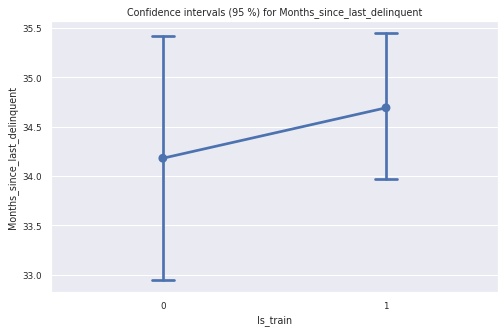

In [46]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Months_since_last_delinquent', data=Months_since_last_delinquent_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Months_since_last_delinquent')
plt.show()

**Credit_Score**

In [47]:
mannwhitneyu(df_train['Credit_Score'], df_test['Credit_Score'])

MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)

In [48]:
Credit_Score_for_compare = for_compare('Credit_Score')

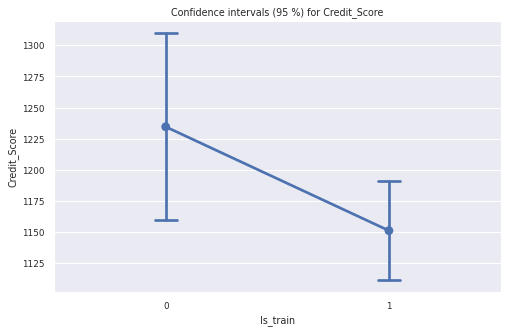

In [49]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Credit_Score', data=Credit_Score_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit_Score')
plt.show()

На kdeplot графики совпадают. Нужно оставить признак. 

**Tax_Liens**

In [50]:
shapiro(df_train['Tax_Liens'])

ShapiroResult(statistic=0.08825808763504028, pvalue=0.0)

In [51]:
shapiro(df_test['Tax_Liens'])

ShapiroResult(statistic=0.06182676553726196, pvalue=0.0)

In [52]:
mannwhitneyu(df_train['Tax_Liens'], df_test['Tax_Liens'])

MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)

In [53]:
Tax_Liens_for_compare = pd.DataFrame(df_train['Tax_Liens'])

In [54]:
Tax_Liens_for_compare['Is_train'] = 1

In [55]:
Tax_Liens_for_compare2 = pd.DataFrame(df_test['Tax_Liens'])

In [56]:
Tax_Liens_for_compare2['Is_train'] = 0

In [57]:
Tax_Liens_for_compare = pd.concat([Tax_Liens_for_compare, Tax_Liens_for_compare2], axis=0)

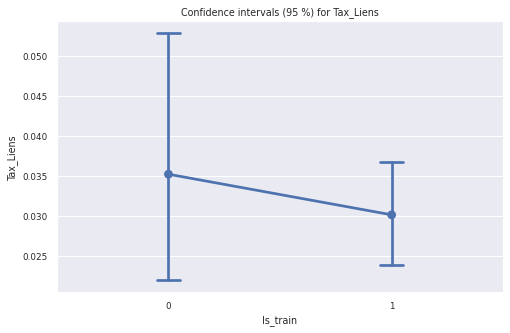

In [58]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Tax_Liens', data=Tax_Liens_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Tax_Liens')
plt.show()

**Number_of_Open_Accounts**

In [59]:
shapiro(df_train['Number_of_Open_Accounts'])

ShapiroResult(statistic=0.9372566342353821, pvalue=0.0)

In [60]:
shapiro(df_test['Number_of_Open_Accounts'])

ShapiroResult(statistic=0.9389863014221191, pvalue=6.676347118885071e-31)

In [61]:
mannwhitneyu(df_train['Number_of_Open_Accounts'], df_test['Number_of_Open_Accounts'])

MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)

In [62]:
Number_of_Open_Accounts_for_compare = for_compare('Number_of_Open_Accounts')

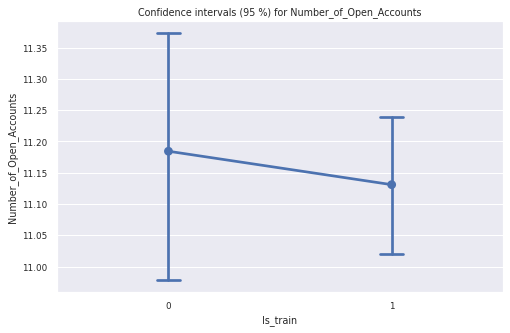

In [63]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Number_of_Open_Accounts', data=Number_of_Open_Accounts_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Number_of_Open_Accounts')
plt.show()

**Years_of_Credit_History**

In [64]:
shapiro(df_train['Years_of_Credit_History'])

ShapiroResult(statistic=0.9434478282928467, pvalue=0.0)

In [65]:
shapiro(df_test['Years_of_Credit_History'])

ShapiroResult(statistic=0.944594144821167, pvalue=1.1355419121372742e-29)

In [66]:
mannwhitneyu(df_train['Years_of_Credit_History'], df_test['Years_of_Credit_History'])

MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)

In [67]:
Years_of_Credit_History_for_compare = for_compare('Years_of_Credit_History')

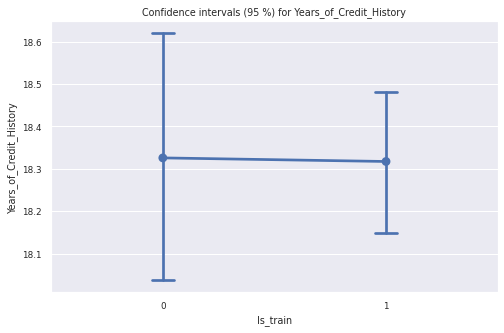

In [68]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Years_of_Credit_History', data=Years_of_Credit_History_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Years_of_Credit_History')
plt.show()

**Maximum_Open_Credit**

In [69]:
shapiro(df_train['Maximum_Open_Credit'])

ShapiroResult(statistic=0.010420262813568115, pvalue=0.0)

In [70]:
shapiro(df_test['Maximum_Open_Credit'])

ShapiroResult(statistic=0.22355026006698608, pvalue=0.0)

In [71]:
mannwhitneyu(df_train['Maximum_Open_Credit'], df_test['Maximum_Open_Credit'])

MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)

In [72]:
Maximum_Open_Credit_for_compare = for_compare('Maximum_Open_Credit')

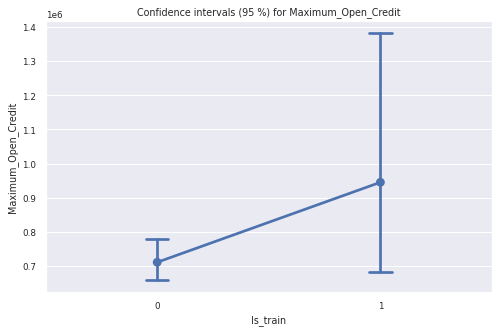

In [73]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Maximum_Open_Credit', data=Maximum_Open_Credit_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Maximum_Open_Credit')
plt.show()

На kdeplot большая разница по плотности, но в целом видно совпадение. Оставить.

**Number_of_Credit_Problems**

In [74]:
shapiro(df_train['Number_of_Credit_Problems'])

ShapiroResult(statistic=0.37480640411376953, pvalue=0.0)

In [75]:
shapiro(df_test['Number_of_Credit_Problems'])

ShapiroResult(statistic=0.29248303174972534, pvalue=0.0)

In [76]:
mannwhitneyu(df_train['Number_of_Credit_Problems'], df_test['Number_of_Credit_Problems'])

MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)

In [77]:
Number_of_Credit_Problems_for_compare = for_compare('Number_of_Credit_Problems')

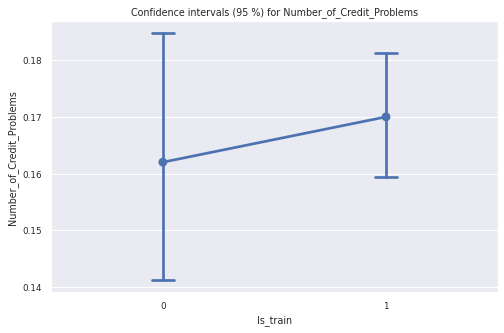

In [78]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Number_of_Credit_Problems', data=Number_of_Credit_Problems_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Number_of_Credit_Problems')
plt.show()

**Bankruptcies**

Здесь небольшое количество Nanов

In [79]:
shapiro(df_train_med['Bankruptcies'])

ShapiroResult(statistic=0.3612915873527527, pvalue=0.0)

In [80]:
shapiro(df_test_med['Bankruptcies'])

ShapiroResult(statistic=0.31436777114868164, pvalue=0.0)

In [81]:
mannwhitneyu(df_train_med['Bankruptcies'], df_test_med['Bankruptcies'])

MannwhitneyuResult(statistic=9260973.0, pvalue=0.04432950519761078)

In [82]:
Bankruptcies_for_compare = for_compare('Bankruptcies')

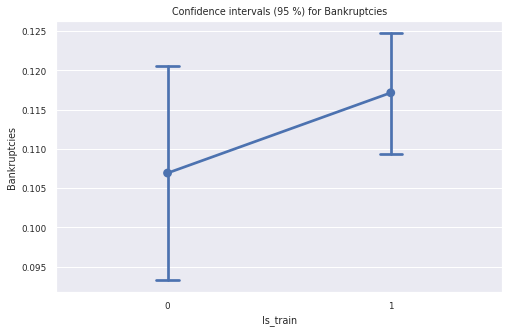

In [83]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Bankruptcies', data=Bankruptcies_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Bankruptcies')
plt.show()

На kdeplot графики визуально совпадают. Оставить.

**Current_Loan_Amount**

In [84]:
shapiro(df_train['Current_Loan_Amount'])

ShapiroResult(statistic=0.37670987844467163, pvalue=0.0)

In [85]:
shapiro(df_test['Current_Loan_Amount'])

ShapiroResult(statistic=0.3815702199935913, pvalue=0.0)

In [86]:
mannwhitneyu(df_train['Current_Loan_Amount'], df_test['Current_Loan_Amount'])

MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)

In [87]:
Current_Loan_Amount_for_compare = for_compare('Current_Loan_Amount')

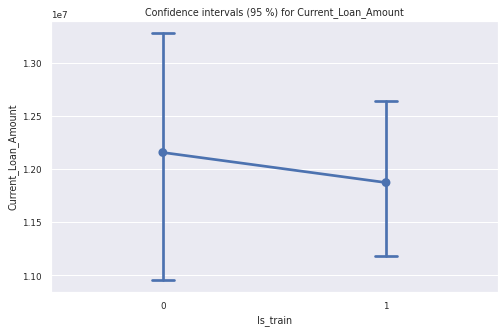

In [88]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Current_Loan_Amount', data=Current_Loan_Amount_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Current_Loan_Amount')
plt.show()

**Current_Credit_Balance**

In [89]:
shapiro(df_train['Current_Credit_Balance'])

ShapiroResult(statistic=0.6394237279891968, pvalue=0.0)

In [90]:
shapiro(df_test['Current_Credit_Balance'])

ShapiroResult(statistic=0.53226637840271, pvalue=0.0)

In [91]:
mannwhitneyu(df_train['Current_Credit_Balance'], df_test['Current_Credit_Balance'])

MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)

In [92]:
Current_Credit_Balance_for_compare = for_compare('Current_Credit_Balance')

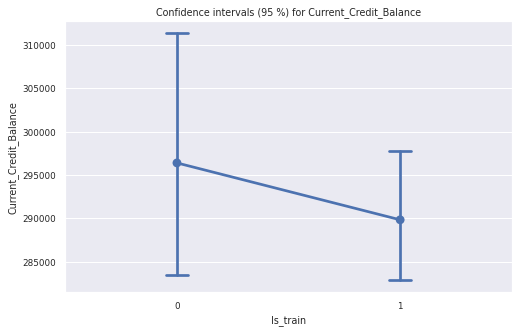

In [93]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Current_Credit_Balance', data=Current_Credit_Balance_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Current_Credit_Balance')
plt.show()

**Monthly_Debt**

In [94]:
shapiro(df_train['Monthly_Debt'])

ShapiroResult(statistic=0.8937593698501587, pvalue=0.0)

In [95]:
shapiro(df_test['Monthly_Debt'])

ShapiroResult(statistic=0.9200007319450378, pvalue=1.6800100977104822e-34)

In [96]:
mannwhitneyu(df_train['Monthly_Debt'], df_test['Monthly_Debt'])

MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)

In [97]:
Monthly_Debt_for_compare = for_compare('Monthly_Debt')

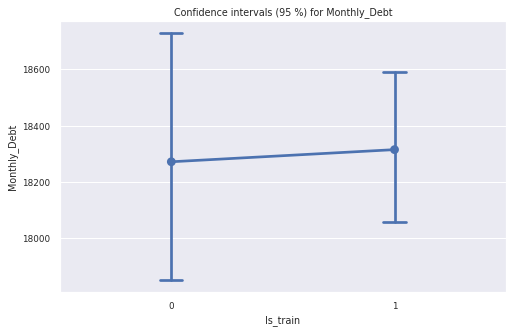

In [98]:
plt.figure(figsize=(8, 5))

sns.pointplot(x='Is_train', y='Monthly_Debt', data=Monthly_Debt_for_compare, capsize=.1)

plt.title('Confidence intervals (95 %) for Monthly_Debt')
plt.show()

**Категориальные признаки**

**Home_Ownership_for_compare**

In [99]:
Home_Ownership_for_compare = for_compare('Home_Ownership')

In [100]:
Home_Ownership_for_compare['id']=Home_Ownership_for_compare.index

In [101]:
table = Home_Ownership_for_compare.pivot_table(values='id', index='Is_train', columns='Home_Ownership', aggfunc='count')
table

Home_Ownership  Have Mortgage  Home Mortgage  Own Home  Rent
Is_train                                                    
0                           7           1225       248  1020
1                          12           3637       647  3204

In [102]:
chi2, p, _, _ = chi2_contingency(table)
p

0.0835358982760327

**Years_in_current_job**

In [103]:
Years_in_current_job_for_compare = for_compare('Years_in_current_job')
Years_in_current_job_for_compare['id']=Years_in_current_job_for_compare.index
table = Years_in_current_job_for_compare.pivot_table(values='id', index='Is_train', columns='Years_in_current_job', aggfunc='count')
table

Years_in_current_job  1 year  10+ years  2 years  3 years  4 years  5 years  \
Is_train                                                                      
0                        153        810      212      228      152      169   
1                        504       2332      705      620      469      516   

Years_in_current_job  6 years  7 years  8 years  9 years  < 1 year  
Is_train                                                            
0                         137      140      107       99       207  
1                         426      396      339      259       563

In [104]:
chi2, p, _, _ = chi2_contingency(table)
p

0.5763919572589815

**Purpose**

In [105]:
Purpose_for_compare = for_compare('Purpose')
Purpose_for_compare['id']=Purpose_for_compare.index
table = Purpose_for_compare.pivot_table(values='id', index='Is_train', columns='Purpose', aggfunc='count')
table

Purpose   business loan  buy a car  buy house  debt consolidation  \
Is_train                                                            
0                  30.0       34.0       19.0              1973.0   
1                 129.0       96.0       34.0              5944.0   

Purpose   educational expenses  home improvements  major purchase  \
Is_train                                                            
0                          3.0              140.0             9.0   
1                         10.0              412.0            40.0   

Purpose   medical bills  moving  other  renewable energy  small business  \
Is_train                                                                   
0                  27.0     1.0  240.0               NaN             5.0   
1                  71.0    11.0  665.0               2.0            26.0   

Purpose   take a trip  vacation  wedding  
Is_train                                  
0                14.0       3.0      2.0  
1                37.0       8.0     15.0

In [106]:
table.drop('renewable energy', axis=1, inplace=True)

In [107]:
chi2, p, _, _ = chi2_contingency(table)
p

0.36257788812150127

**Term**

In [108]:
Term_for_compare = for_compare('Term')
Term_for_compare['id']=Term_for_compare.index
table = Term_for_compare.pivot_table(values='id', index='Is_train', columns='Term', aggfunc='count')
table

Term      Long Term  Short Term
Is_train                       
0               639        1861
1              1944        5556

In [109]:
chi2, p, _, _ = chi2_contingency(table)
p

0.7415784078538388

## 3. **Корреляция с базовыми признаками**  <a class='anchor' id='eda'>

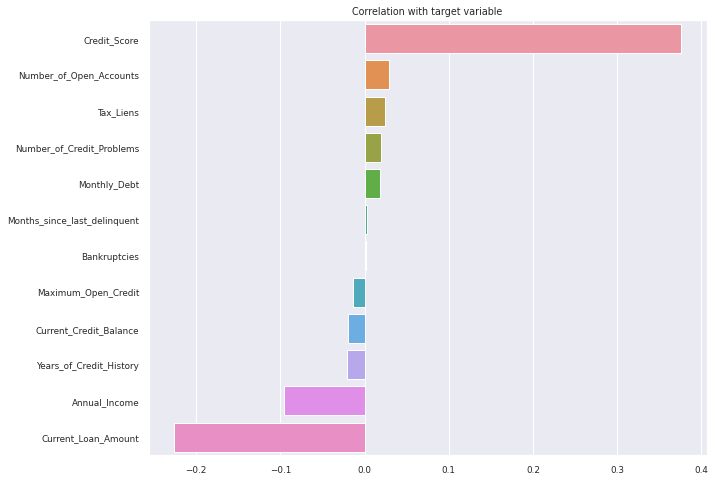

In [110]:
corr_with_target = df_train_med[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Исследую Credit_Score, Annual_Income и Current_Loan_Amount

**Credit_Score**

In [111]:
df_train.Credit_Score.isna().sum()

1557

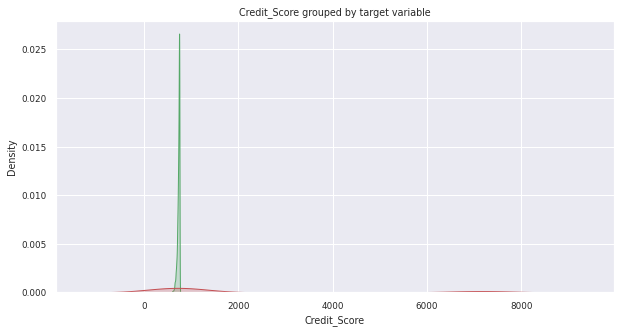

In [112]:
Credit_Score_with_target = df_train[['Credit_Score', TARGET_NAME]]
Credit_Score = Credit_Score_with_target['Credit_Score']
Credit_Score_target_0 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 0] 
Credit_Score_target_1 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Credit_Score_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Credit_Score')
plt.title('Credit_Score grouped by target variable')
plt.show()

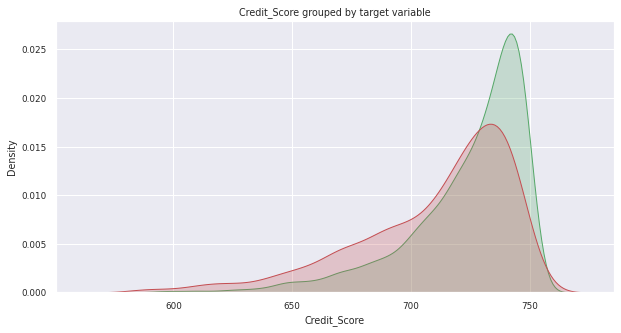

In [113]:
plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0[df_train.Credit_Score < 2000], shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Credit_Score_target_1[df_train.Credit_Score < 2000], shade=True, label='Просрочка', color='r')

plt.xlabel('Credit_Score')
plt.title('Credit_Score grouped by target variable')
plt.show()

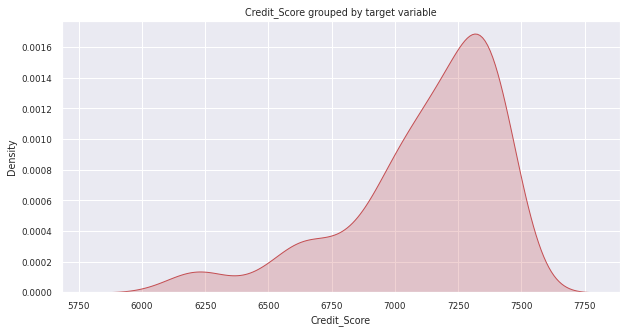

In [114]:
plt.figure(figsize=(10, 5))

sns.kdeplot(Credit_Score_target_0[df_train.Credit_Score > 6000], shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Credit_Score_target_1[df_train.Credit_Score > 6000], shade=True, label='Просрочка', color='r')

plt.xlabel('Credit_Score')
plt.title('Credit_Score grouped by target variable')
plt.show()

На 1 видно выбросы справа, с ними что-то надо делать. Признак качественный, но много Нанов.

**Annual_Income**

In [115]:
df_train.Annual_Income.isna().sum()

1557

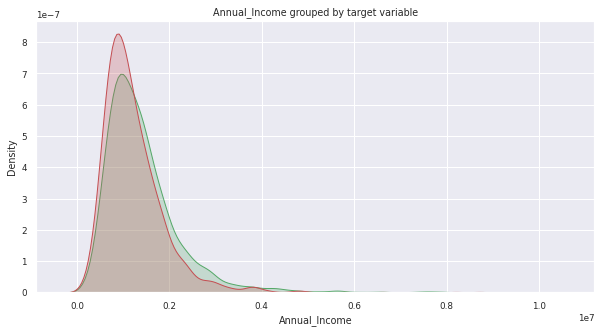

In [116]:
Annual_Income_with_target = df_train[['Annual_Income', TARGET_NAME]]
Annual_Income = Annual_Income_with_target['Annual_Income']
Annual_Income_target_0 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 0] 
Annual_Income_target_1 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Annual_Income_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Annual_Income_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Annual_Income')
plt.title('Annual_Income grouped by target variable')
plt.show()

In [117]:
shapiro(df_train_med['Annual_Income'])

ShapiroResult(statistic=0.7313876152038574, pvalue=0.0)

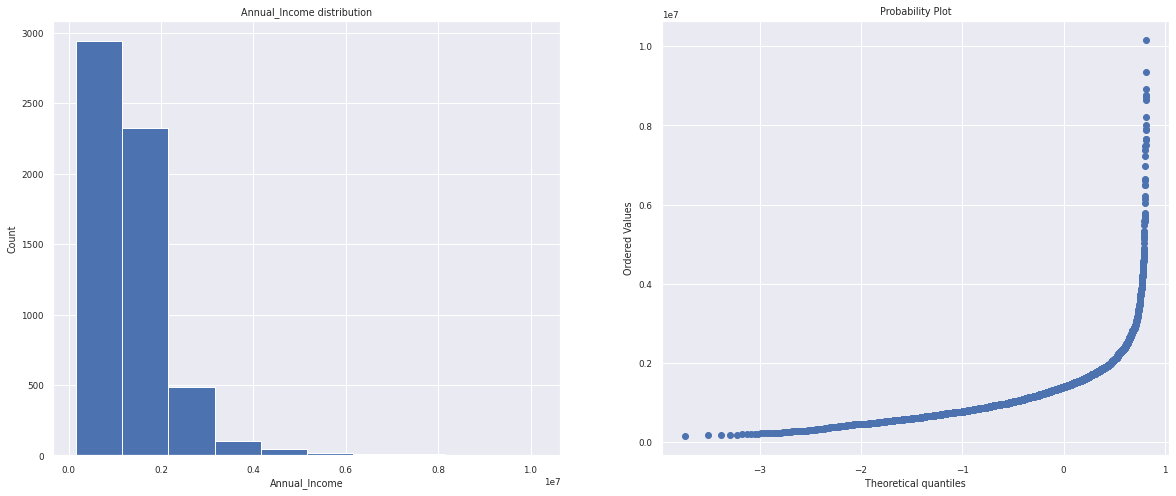

In [118]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Annual_Income')
ax1.set_ylabel('Count')
ax1.set_title('Annual_Income distribution')
Annual_Income.hist()

plt.subplot(122)
probplot(Annual_Income, dist='norm', plot=plt)

plt.show()

Воспользуюсь критерием Манна_Уитни для проверки гипотезы о равности матожиданий.

In [119]:
mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

MannwhitneyuResult(statistic=5534342.5, pvalue=0.031334788783133206)

Построю доверительные интервалы

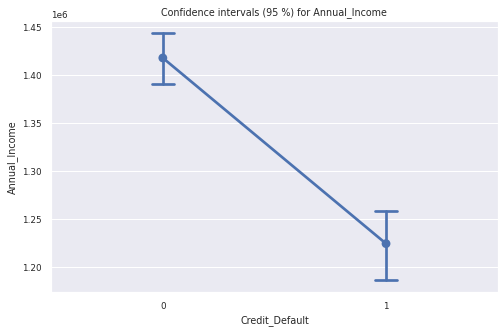

In [120]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Annual_Income', data=Annual_Income_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Annual_Income')
plt.show()

Гипотеза о равности средних отвергается. Признак полезный. На "нулевом" графике есть выбросы справа но для погашенной задолженности это логично.

**Current_Loan_Amount**

In [121]:
df_train.Current_Loan_Amount.isna().sum()

0

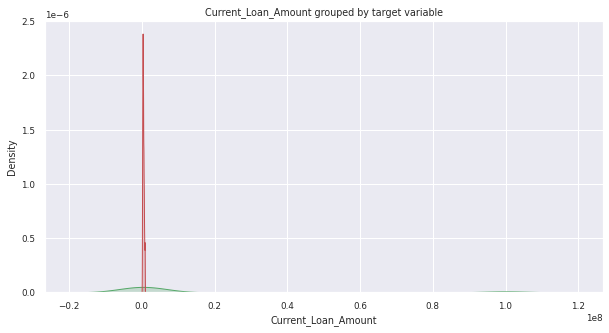

In [122]:
Current_Loan_Amount_with_target = df_train[['Current_Loan_Amount', TARGET_NAME]]
Current_Loan_Amount = Current_Loan_Amount_with_target['Current_Loan_Amount']
Current_Loan_Amount_target_0 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 0] 
Current_Loan_Amount_target_1 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Loan_Amount_target_0, shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Current_Loan_Amount_target_1, shade=True, label='Просрочка', color='r')

plt.xlabel('Current_Loan_Amount')
plt.title('Current_Loan_Amount grouped by target variable')
plt.show()

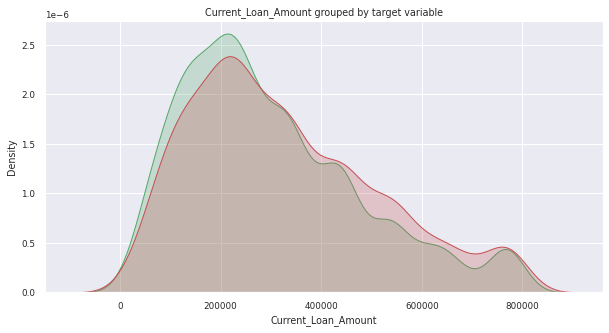

In [123]:
plt.figure(figsize=(10, 5))

sns.kdeplot(Current_Loan_Amount_target_0[Current_Loan_Amount_with_target.Current_Loan_Amount < 20000000], shade=True, label='Погашен вовремя', color='g')
sns.kdeplot(Current_Loan_Amount_target_1[Current_Loan_Amount_with_target.Current_Loan_Amount < 20000000], shade=True, label='Просрочка', color='r')

plt.xlabel('Current_Loan_Amount')
plt.title('Current_Loan_Amount grouped by target variable')
plt.show()

In [124]:
shapiro(df_train['Current_Loan_Amount'])

ShapiroResult(statistic=0.37670987844467163, pvalue=0.0)

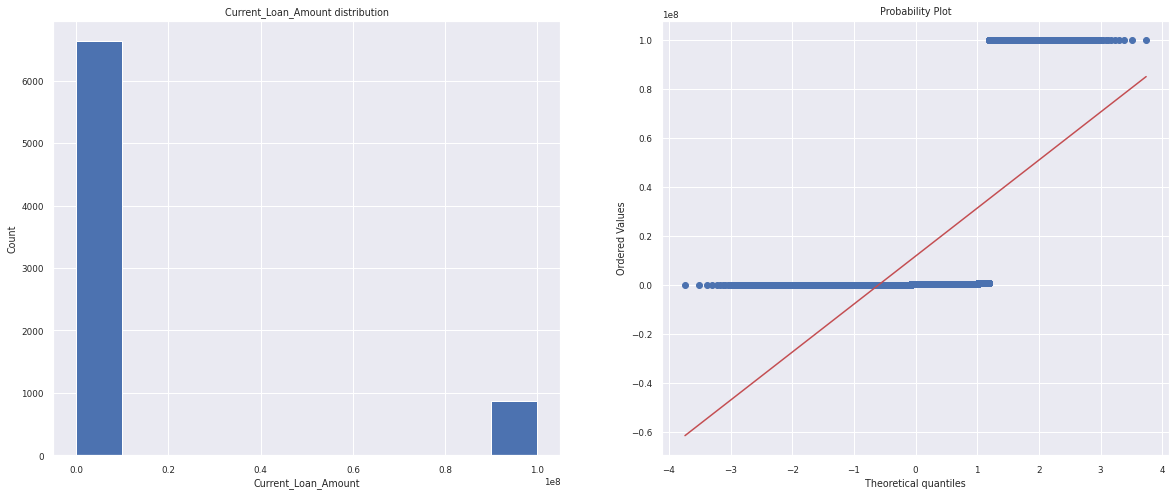

In [125]:
plt.figure(figsize=(20, 8))

ax1 = plt.subplot(121)
ax1.set_xlabel('Current_Loan_Amount')
ax1.set_ylabel('Count')
ax1.set_title('Current_Loan_Amount distribution')
Current_Loan_Amount.hist()

plt.subplot(122)
probplot(Current_Loan_Amount, dist='norm', plot=plt)

plt.show()

In [126]:
mannwhitneyu(Current_Loan_Amount_target_0, Current_Loan_Amount_target_1)

MannwhitneyuResult(statistic=5169258.0, pvalue=2.923443678733522e-10)

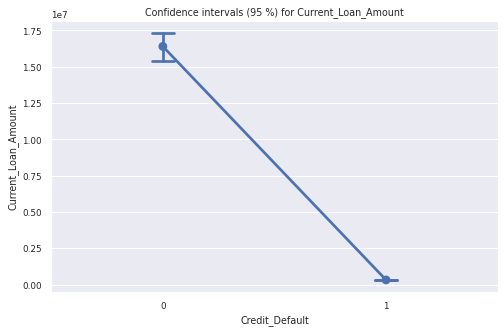

In [127]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Current_Loan_Amount', data=Current_Loan_Amount_with_target, capsize=.1)

plt.title('Confidence intervals (95 %) for Current_Loan_Amount')
plt.show()

Признак полезный. 

## 4. **Работа с категориальными признаками**  <a class='anchor' id='eda'>

Строю доверительные интервалы по полной наиболее коррелирующей c целевой фиче.

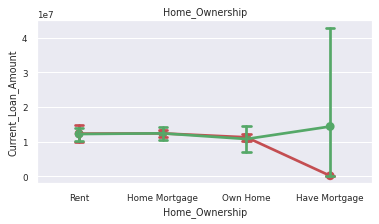

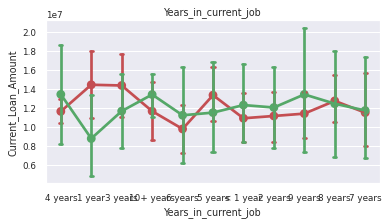

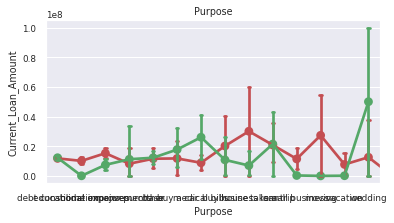

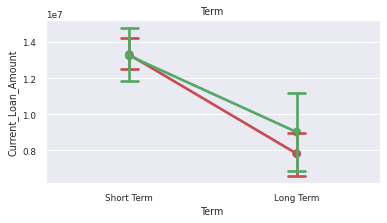

In [128]:
num_feature = 'Current_Loan_Amount'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

In [129]:
df_train_cat = df_train[CAT_FEATURE_NAMES + [TARGET_NAME]]
df_train['Id'] = df_train.index
df_train.head()

Home_Ownership  Annual_Income Years_in_current_job  Tax_Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number_of_Open_Accounts  Years_of_Credit_History  Maximum_Open_Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number_of_Credit_Problems  Months_since_last_delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current_Loan_Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current_Credit_Balance  Monthly_Debt  Credit_Score  Credit_Default  Id  
0                 47386.0        7914.0         749.0               0   0  
1                394972.0       18373.0         737.0               1   1  
2                308389.0       13651.0         742.0               0   2  
3                 95855.0       11338.0         694.0               0   3  
4                 93309.0        7180.0         719.0               0   4

In [130]:
keys2=[]

In [131]:
def corr_for_terget(feature, keys=keys2, df=df_train):
    # Построение матрицы корреляции
    keys2.sort()
    values2 = [1] * len(keys2)
    values3=[]
    for i in range(len(keys2)):
        values3.append(values2)
    dictionary = dict(zip(keys2, values3))
    Matrix=pd.DataFrame(dictionary)
    b=pd.Series(keys2)
    Matrix.insert(0, 'Item', b)   
    for i in range(len(keys2)):
        for j in range(len(keys2)):
            feature_and_target_s = df.loc[df[feature].isin([keys2[i], keys2[j]]),['Id', feature, TARGET_NAME]]
            table = feature_and_target_s.pivot_table(values='Id', index=feature, columns=TARGET_NAME, aggfunc='count')
            chi2, p, _, _ = chi2_contingency(table)
            Matrix.loc[i, keys2[j]] = p 
    Matrix.set_index('Item', inplace=True)

    return Matrix 

**Оценка признака "Home_Ownership" в разрезе целевой переменной**

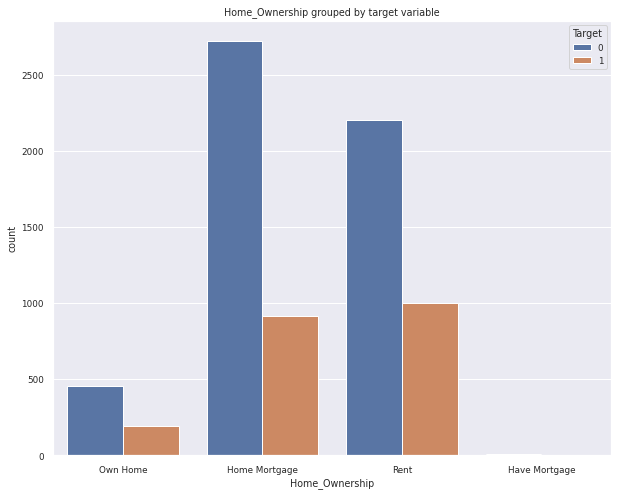

In [133]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home_Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home_Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [134]:
df_train.Home_Ownership.unique().tolist()

['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']

In [135]:
keys2=['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']

In [136]:
Matrix=corr_for_terget("Home_Ownership", keys=keys2, df=df_train)

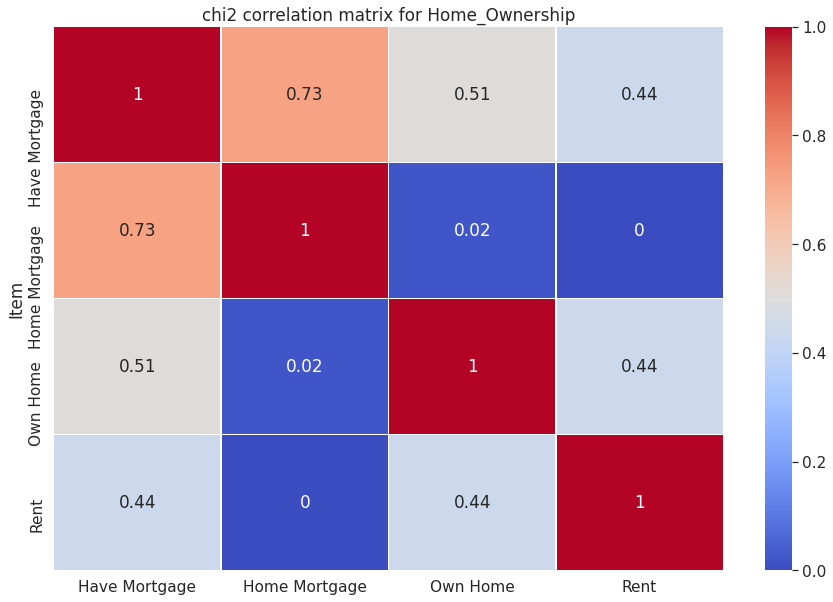

In [137]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2) 
Matrix[np.abs(Matrix) < 0.1] 
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for Home_Ownership')
plt.show()

Объединяю значения

In [138]:
def change_Home_Ownership(df):
    df.loc[df['Home_Ownership'].isin(['Home Mortgage', 'Have Mortgage']),'Home_Ownership'] = 'Mortgage'
    df.loc[df['Home_Ownership'].isin(['Own Home', 'Rent']), 'Home_Ownership'] = 'Own_Rent'
    return df

In [139]:
df_train=change_Home_Ownership(df_train)
df_test=change_Home_Ownership(df_test)

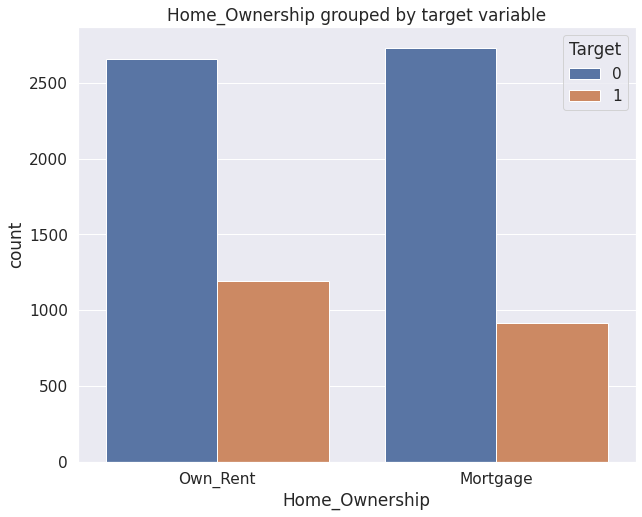

In [140]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Home_Ownership", hue=TARGET_NAME, data=df_train)
plt.title('Home_Ownership grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

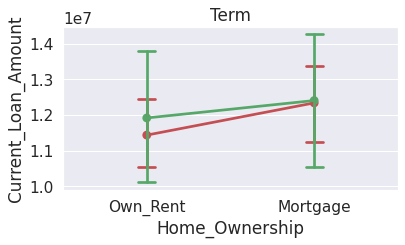

In [141]:
plt.figure(figsize=figsize)
sns.pointplot(x='Home_Ownership', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x='Home_Ownership', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

На Катбусте целевая метрика при объединении упала с 0,57/0,54 до 0,62/0,54

**Оценка признака "Years_in_current_job" в разрезе целевой переменной**

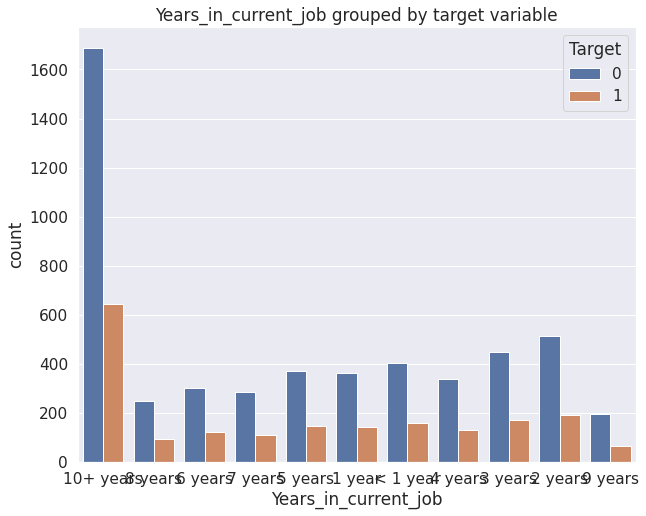

In [142]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years_in_current_job", hue=TARGET_NAME, data=df_train)
plt.title('Years_in_current_job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [143]:
df_train['Years_in_current_job'].unique().tolist()

[nan,
 '10+ years',
 '8 years',
 '6 years',
 '7 years',
 '5 years',
 '1 year',
 '< 1 year',
 '4 years',
 '3 years',
 '2 years',
 '9 years']

In [144]:
keys2 = ['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years',
         '3 years', '2 years', '9 years']
keys2.sort()

In [145]:
values2 = [1] * len(keys2)
values3=[]

In [146]:
for i in range(len(keys2)):
    values3.append(values2)

In [147]:
dictionary = dict(zip(keys2, values3))
Matrix=pd.DataFrame(dictionary)

In [148]:
b=pd.Series(keys2)
Matrix.insert(0, 'Item', b)

In [149]:
for i in range(len(keys2)):
    for j in range(len(keys2)):
        Years_in_current_job_and_target_s = df_train.loc[df_train['Years_in_current_job'].isin([keys2[i], keys2[j]]),['Id', 'Years_in_current_job', TARGET_NAME]]
        table = Years_in_current_job_and_target_s.pivot_table(values='Id', index='Years_in_current_job', columns=TARGET_NAME, aggfunc='count')
        chi2, p, _, _ = chi2_contingency(table)
        Matrix.loc[i, keys2[j]] = p

In [150]:
Matrix.set_index('Item', inplace=True)

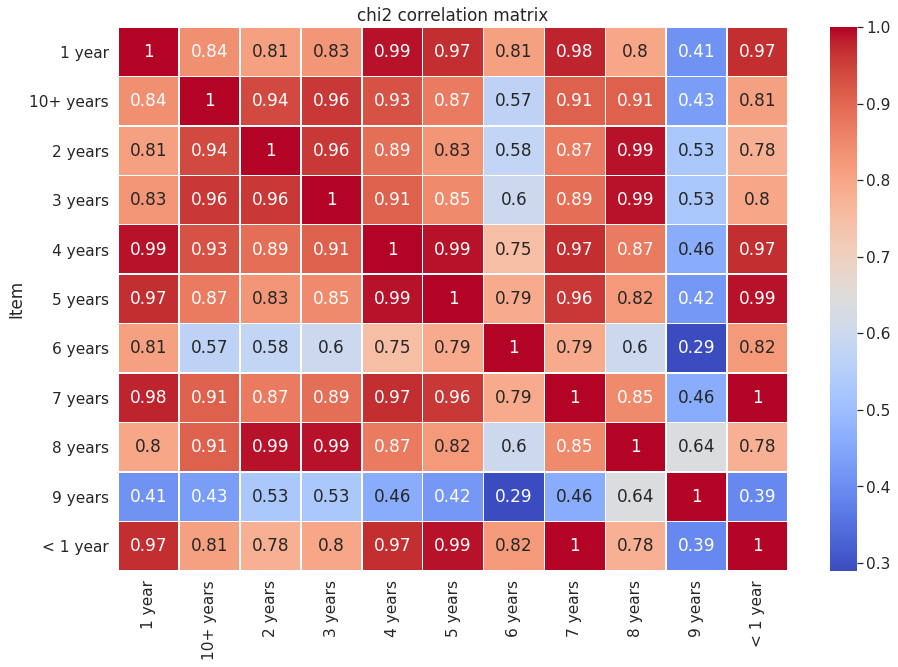

In [151]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2) 
Matrix[np.abs(Matrix) < 0.1] = 0 
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix')
plt.show()

Все значения в признаке "Years_in_current_job" в разрезе целевой переменной коррелируют. Но удаление признака ухудшило целевую метрику.

In [152]:
df_train.drop("Years_in_current_job", axis=1, inplace=True)

In [153]:
df_test.drop("Years_in_current_job", axis=1, inplace=True)

**Оценка признака "Purpose" в разрезе целевой переменной**

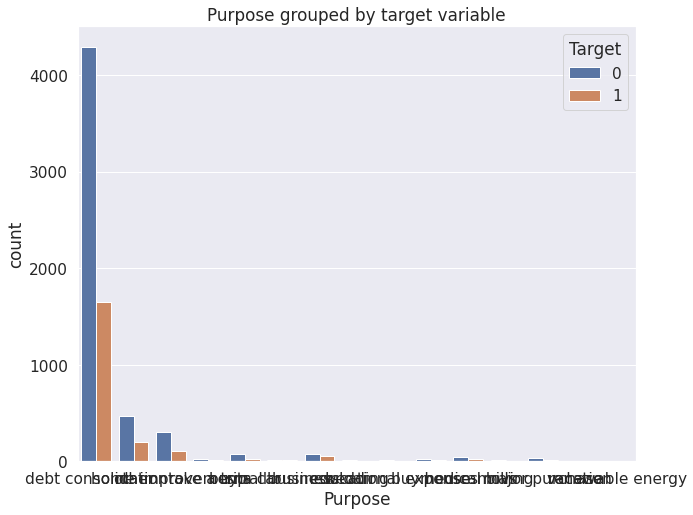

In [154]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
plt.title('Purpose grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [155]:
df_train.Purpose.isna().sum()

0

In [156]:
df_train.Purpose.unique().tolist()

['debt consolidation',
 'other',
 'home improvements',
 'take a trip',
 'buy a car',
 'small business',
 'business loan',
 'wedding',
 'educational expenses',
 'buy house',
 'medical bills',
 'moving',
 'major purchase',
 'vacation',
 'renewable energy']

In [157]:
keys2 = ['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses',
          'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']

In [158]:
Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

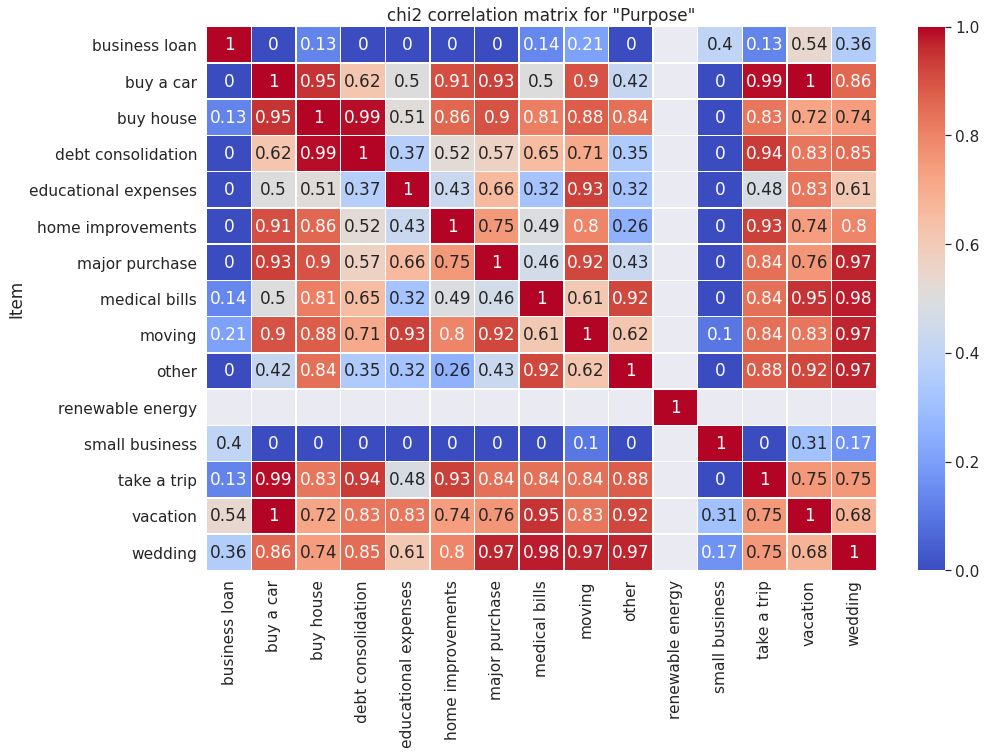

In [159]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2) 
Matrix[np.abs(Matrix) < 0.1] = 0  
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for "Purpose"')
plt.show()

Объединю признаки. Это общая функция для всех 3 преобразований.

In [160]:
def change_Purpose(df):
    df.loc[df['Purpose'].isin(['take a trip', 'buy a car']),'Purpose'] = 'take_buy'
    df.loc[df['Purpose'].isin(['medical bills', 'wedding']), 'Purpose'] = 'medical_wedding'
    df.loc[df['Purpose'].isin(['other', 'vacation']),'Purpose'] = 'other_vacation'
    df.loc[df['Purpose'].isin(['educational expenses', 'moving']), 'Purpose'] = 'educational_moving'
    df.loc[df['Purpose'].isin(['buy house', 'major purchase']),'Purpose'] = 'buy_major'
    df.loc[df['Purpose'].isin(['small business', 'business loan']),'Purpose'] = 'business_small'
    df.loc[df['Purpose'].isin(['take_buy', 'buy_major']),'Purpose'] = 'major_buy'
    df.loc[df['Purpose'].isin(['debt consolidation', 'home improvements']), 'Purpose'] = 'debt_home'
    df.loc[df['Purpose'].isin(['educational_moving', 'medical_wedding']),'Purpose'] = 'educational_medical'
    df.loc[df['Purpose'].isin(['debt_home', 'educational_medical']),'Purpose'] = 'educational_debt'
    df.loc[df['Purpose'].isin(['other_vacation', 'major_buy']), 'Purpose'] = 'other_major'
    
    return df

In [161]:
def change_Purpose2(df):
    df.loc[df['Purpose'].isin(['take_buy', 'buy_major']),'Purpose'] = 'major_buy'
    df.loc[df['Purpose'].isin(['debt consolidation', 'home improvements']), 'Purpose'] = 'debt_home'
    df.loc[df['Purpose'].isin(['educational_moving', 'medical_wedding']),'Purpose'] = 'educational_medical'

    return df

In [162]:
def change_Purpose3(df):
    df.loc[df['Purpose'].isin(['debt_home', 'educational_medical']),'Purpose'] = 'educational_debt'
    df.loc[df['Purpose'].isin(['other_vacation', 'major_buy']), 'Purpose'] = 'other_major'

    return df

In [163]:
df_train=change_Purpose(df_train)
df_test=change_Purpose(df_test)

In [164]:
df_train.head()

Home_Ownership  Annual_Income  Tax_Liens  Number_of_Open_Accounts  \
0       Own_Rent       482087.0        0.0                     11.0   
1       Own_Rent      1025487.0        0.0                     15.0   
2       Mortgage       751412.0        0.0                     11.0   
3       Own_Rent       805068.0        0.0                      8.0   
4       Own_Rent       776264.0        0.0                     13.0   

   Years_of_Credit_History  Maximum_Open_Credit  Number_of_Credit_Problems  \
0                     26.3             685960.0                        1.0   
1                     15.3            1181730.0                        0.0   
2                     35.0            1182434.0                        0.0   
3                     22.5             147400.0                        1.0   
4                     13.6             385836.0                        1.0   

   Months_since_last_delinquent  Bankruptcies           Purpose        Term  \
0                           NaN           1.0  educational_debt  Short Term   
1                           NaN           0.0  educational_debt   Long Term   
2                           NaN           0.0  educational_debt  Short Term   
3                           NaN           1.0  educational_debt  Short Term   
4                           NaN           0.0  educational_debt  Short Term   

   Current_Loan_Amount  Current_Credit_Balance  Monthly_Debt  Credit_Score  \
0           99999999.0                 47386.0        7914.0         749.0   
1             264968.0                394972.0       18373.0         737.0   
2           99999999.0                308389.0       13651.0         742.0   
3             121396.0                 95855.0       11338.0         694.0   
4             125840.0                 93309.0        7180.0         719.0   

   Credit_Default  Id  
0               0   0  
1               1   1  
2               0   2  
3               0   3  
4               0   4

In [165]:
df_train.Purpose.unique().tolist()

['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [166]:
keys2=['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [167]:
Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

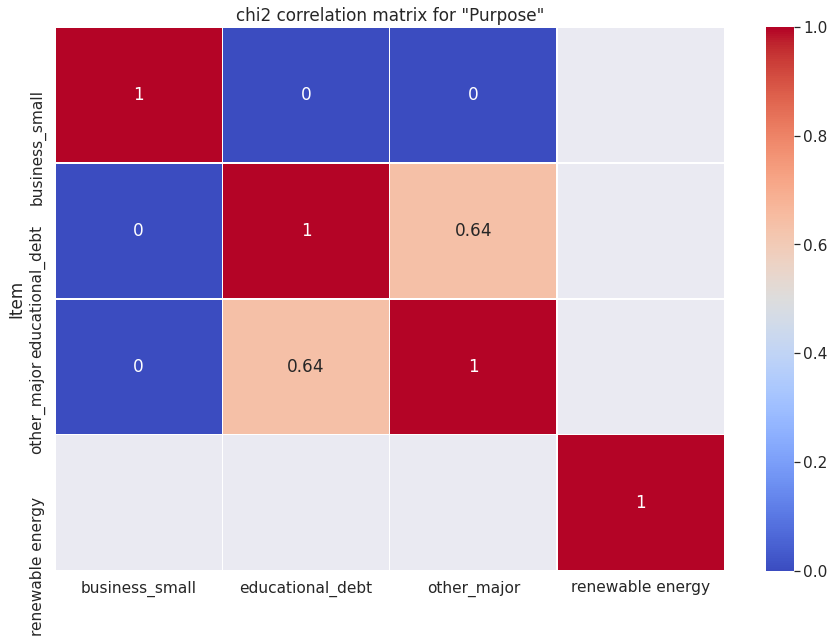

In [168]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2)  
Matrix[np.abs(Matrix) < 0.1] = 0  
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for "Purpose"')
plt.show()

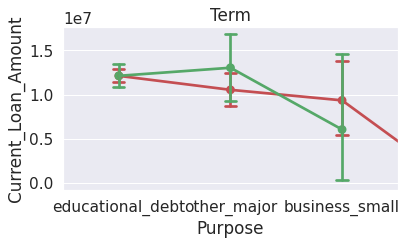

In [169]:
plt.figure(figsize=figsize)
sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

In [170]:
df_train=change_Purpose2(df_train)
df_test=change_Purpose2(df_test)

In [171]:
df_train.Purpose.unique().tolist()

['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [172]:
keys2=['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [173]:
Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

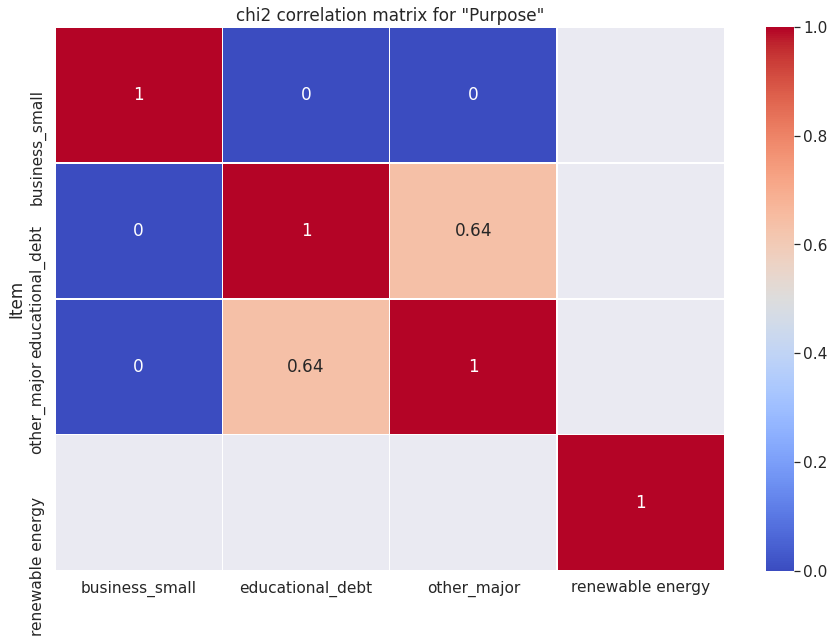

In [174]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2) 
Matrix[np.abs(Matrix) < 0.1] = 0  
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for "Purpose"')
plt.show()

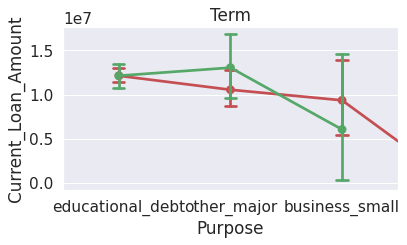

In [175]:
plt.figure(figsize=figsize)
sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

In [176]:
df_train=change_Purpose3(df_train)
df_test=change_Purpose3(df_test)

In [177]:
df_train.Purpose.unique().tolist()

['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [178]:
keys2=['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [179]:
Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

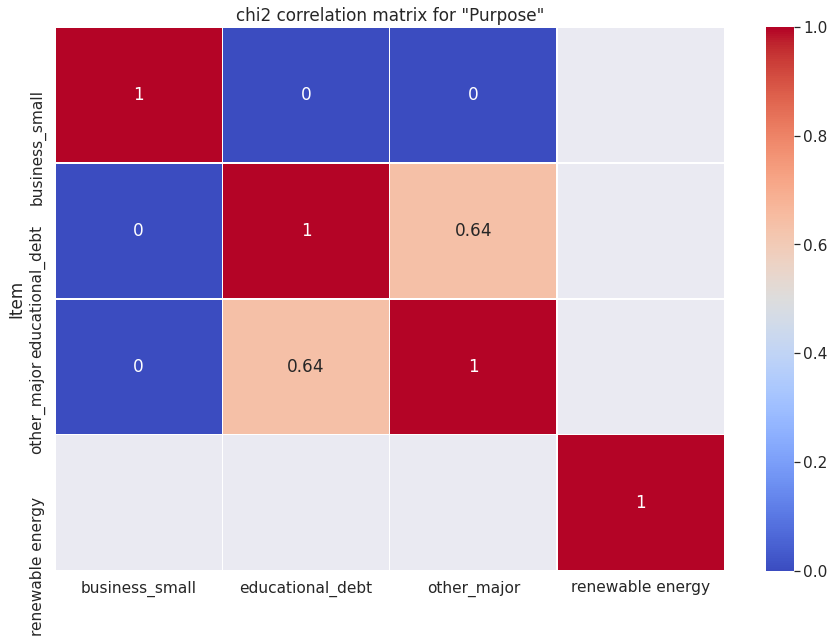

In [180]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2)  
Matrix[np.abs(Matrix) < 0.1] = 0  
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for "Purpose"')
plt.show()

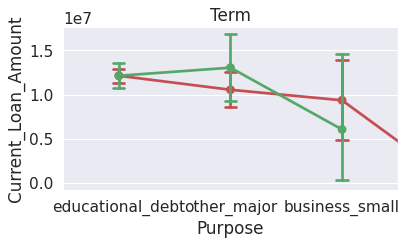

In [181]:
plt.figure(figsize=figsize)
sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

In [182]:
def change_Purpose4(df):
    df.loc[df['Purpose'].isin(['educational_debt', 'other_major']),'Purpose'] = 'game_other'

    return df

In [183]:
df_train=change_Purpose4(df_train)
df_test=change_Purpose4(df_test)

In [184]:
df_train.Purpose.unique().tolist()

['game_other', 'business_small', 'renewable energy']

In [185]:
keys2=['game_other', 'business_small', 'renewable energy']

In [186]:
Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

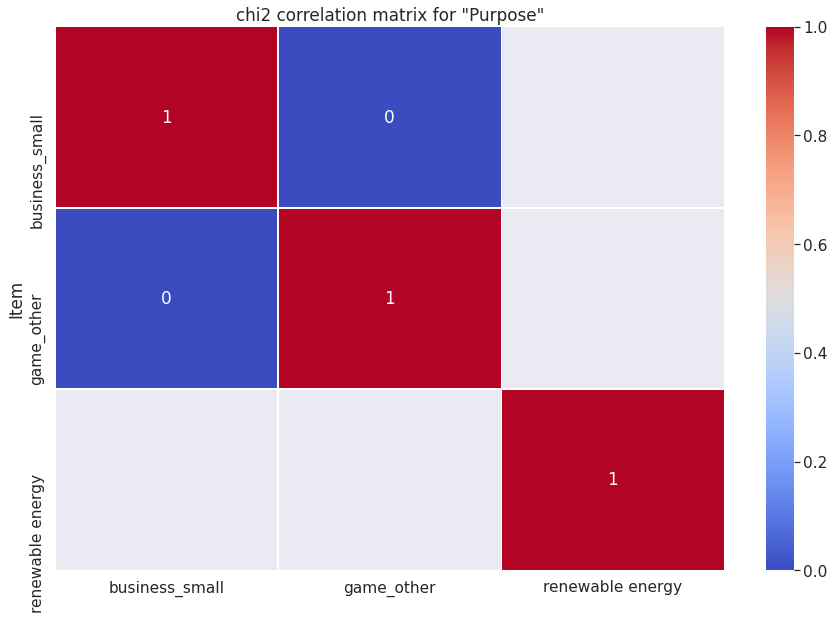

In [187]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)
Matrix = np.round(Matrix, 2)  
Matrix[np.abs(Matrix) < 0.1] = 0  
sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('chi2 correlation matrix for "Purpose"')
plt.show()

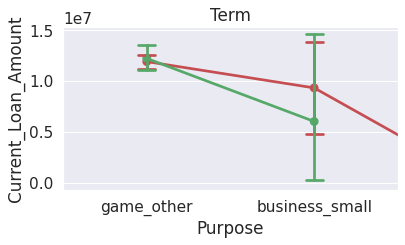

In [188]:
plt.figure(figsize=figsize)
sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
plt.title(col) 
plt.show()

In [189]:
#df_train.Purpose.value_counts()

Да уж. Признак так себе. Преобразование признака увеличило целевую метрику на 0,1

**Оценка признака "Term" в разрезе целевой переменной**

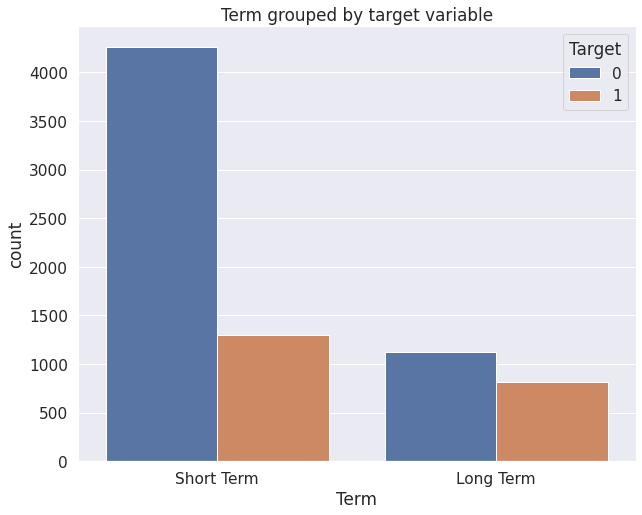

In [190]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Term", hue=TARGET_NAME, data=df_train)
plt.title('Term grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

По гистограмме видно отличие частот.

**GET_DUMMIES**

Гет даммис уменьшил целевую переменную

In [191]:
#df_train=pd.get_dummies(df_train, prefix=['Term', 'Purpose', 'Home_Ownership'])

In [192]:
#df_train.head()

## 5. **ОБРАБОТКА ВЫБРОСОВ**  <a class='anchor' id='eda'>

**Annual_Income**

<AxesSubplot:>

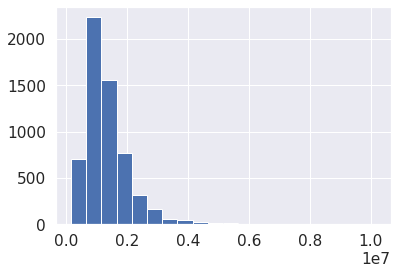

In [193]:
df_train.Annual_Income.hist(bins=20)

<AxesSubplot:>

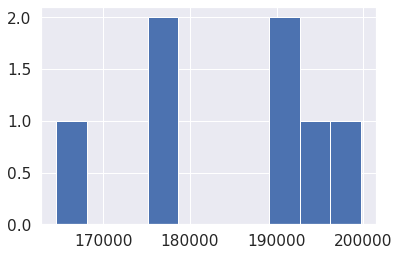

In [194]:
df_train.Annual_Income[df_train['Annual_Income'] < 200000].hist()

доход менее 140000 похож на маленький выброс, он почти на порядок меньше медианы. Заменю пока на 0.

In [195]:
df_train.Annual_Income.median()

1168386.0

In [196]:
df_train.loc[df_train.Annual_Income < 140000, 'Annual_Income'] = 0

<AxesSubplot:>

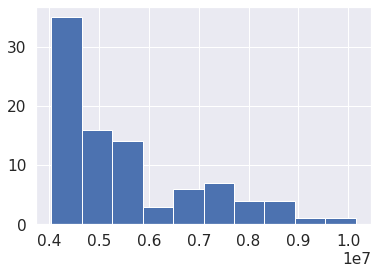

In [197]:
df_train.Annual_Income[df_train['Annual_Income'] > 4000000].hist()

Наибольшая корреляция с Monthly_Debt

In [198]:
df_train.Monthly_Debt.value_counts()

0.0        6
19222.0    4
19667.0    4
9525.0     3
22364.0    3
          ..
12897.0    1
27541.0    1
23227.0    1
55957.0    1
17.0       1
Name: Monthly_Debt, Length: 6716, dtype: int64

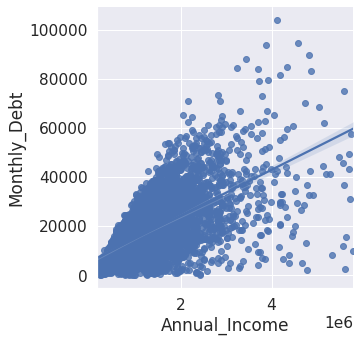

In [199]:
sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 6000000)])

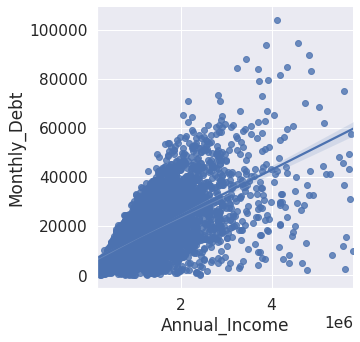

In [200]:
sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 6000000)])

Четко видна линия сопростивления по верхней границе данных с небольшим запасом  от точки (0, 10000) до (2000000, 70000). Все что будет выше нужно обрабатывать.

In [201]:
for idx, row in df_train.iterrows():
    if (row.Monthly_Debt - 10000)/row.Annual_Income > 0.03:
        df_train.loc[idx, 'Monthly_Debt'] = df_train.Monthly_Debt.median()

In [202]:
df_train.Annual_Income[df_train['Annual_Income'] > 11000000].value_counts()

Series([], Name: Annual_Income, dtype: int64)

**Number_of_Open_Accounts**

<AxesSubplot:>

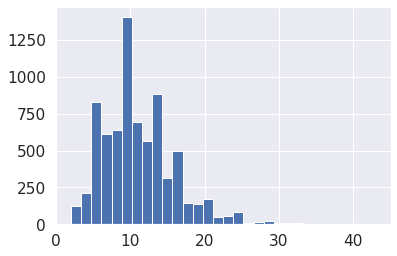

In [203]:
df_train.Number_of_Open_Accounts.hist(bins=30)

Корреляция с Monthly_Debt

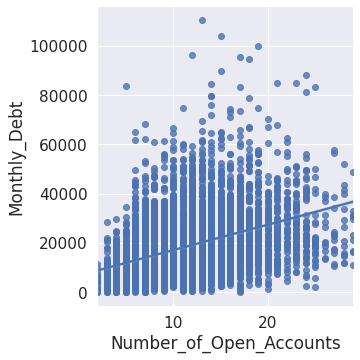

In [204]:
sns.lmplot(x='Number_of_Open_Accounts', y='Monthly_Debt', data=df_train[(df_train.Number_of_Open_Accounts < 30)])

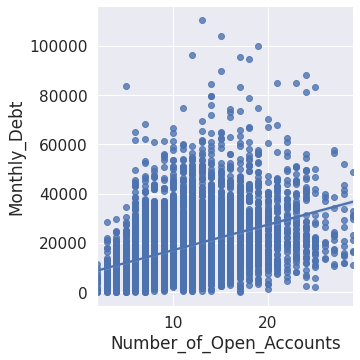

In [205]:
sns.lmplot(x='Number_of_Open_Accounts', y='Monthly_Debt', data=df_train[(df_train.Number_of_Open_Accounts < 30)])

Здесь тоже видна линия сопростивления от точки (0, 30000) до (10, 80000). Выбросов немного, убираем на медиану.

In [206]:
for idx, row in df_train.iterrows():
    if (row.Monthly_Debt - 10000)/row.Number_of_Open_Accounts > 5000:
        df_train.loc[idx, 'Monthly_Debt'] = df_train.Monthly_Debt.median()

<AxesSubplot:>

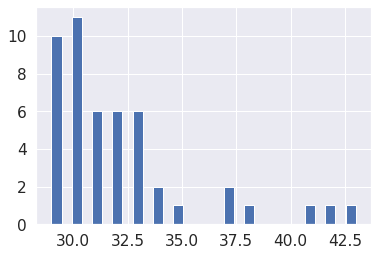

In [207]:
df_train.Number_of_Open_Accounts[df_train.Number_of_Open_Accounts > 28].hist(bins=30)

**Credit_Score**

<AxesSubplot:>

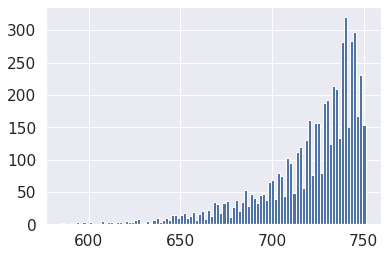

In [208]:
df_train.Credit_Score[df_train.Credit_Score < 1000].hist(bins=100)

<AxesSubplot:>

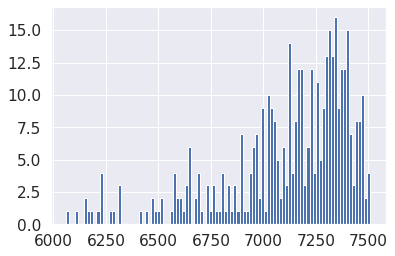

In [209]:
df_train.Credit_Score[df_train.Credit_Score > 900].hist(bins=100)

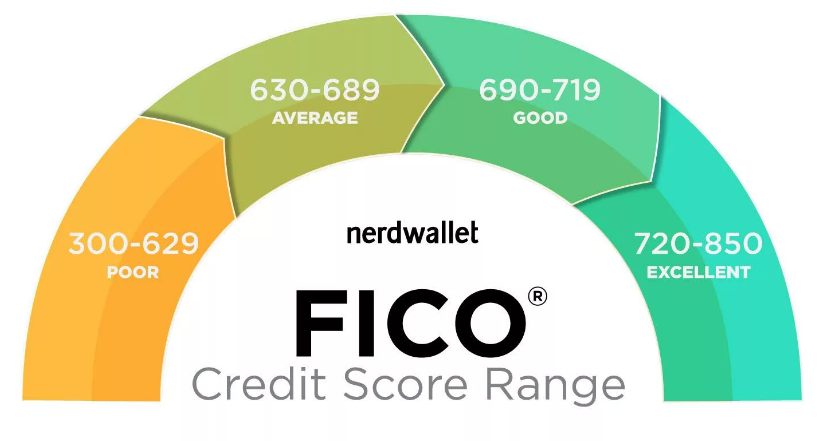

Из гистограмм и картинки видно, что на нижней гистограмме ошиблись с ноликом скорее всего. Исправляю.

In [210]:
for idx, row in df_train.iterrows():
    if (row.Credit_Score > 1000):
        df_train.loc[idx, 'Credit_Score'] = row.Credit_Score/10

**Tax_Liens**

In [211]:
df_train.Tax_Liens.value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax_Liens, dtype: int64

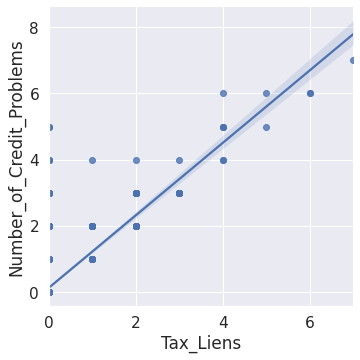

In [212]:
sns.lmplot(x='Tax_Liens', y='Number_of_Credit_Problems', data=df_train[(df_train.Tax_Liens < 30)])

Здесь и обрабатывать то нечего. То что большинство не имеет налогового обременения на счета это нормально.

**Number_of_Credit_Problems**

In [213]:
df_train.Number_of_Credit_Problems.value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number_of_Credit_Problems, dtype: int64

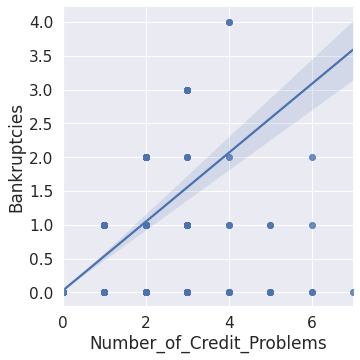

In [214]:
sns.lmplot(y='Bankruptcies', x='Number_of_Credit_Problems', data=df_train[(df_train.Number_of_Credit_Problems < 30)])

Все ровно.

**Current_Loan_Amount**

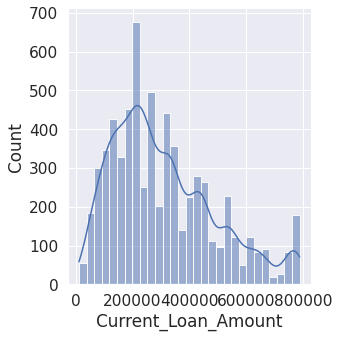

In [215]:
sns.displot(x='Current_Loan_Amount', kde=True,
            data=df_train[df_train.Current_Loan_Amount < 1000000 ])

In [216]:
df_train.Current_Loan_Amount[df_train.Current_Loan_Amount > 2000000 ].value_counts()

99999999.0    870
Name: Current_Loan_Amount, dtype: int64

<AxesSubplot:>

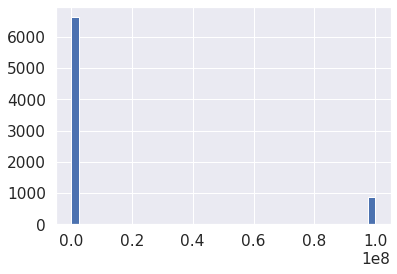

In [217]:
df_train.Current_Loan_Amount.hist(bins=40)

Правый выброс можно приравнять 870 Nan

In [218]:
df_train.loc[df_train.Current_Loan_Amount > 2000000, 'Current_Loan_Amount'] = np.nan

**Monthly_Debt**

<AxesSubplot:>

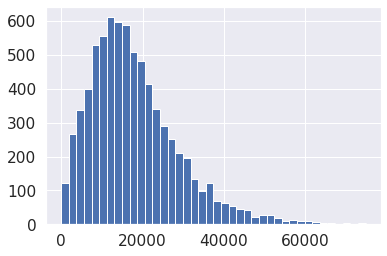

In [219]:
df_train.Monthly_Debt[df_train.Monthly_Debt < 75000].hist(bins=40)

<AxesSubplot:>

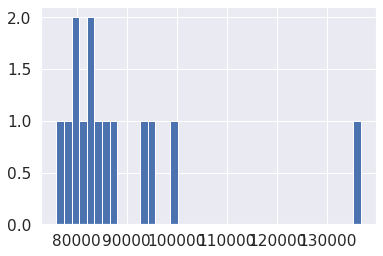

In [220]:
df_train.Monthly_Debt[df_train.Monthly_Debt > 75000].hist(bins=40)

In [221]:
df_train.Monthly_Debt[df_train.Monthly_Debt > 75000].value_counts()

85030.0     1
136679.0    1
84738.0     1
79555.0     1
75910.0     1
83458.0     1
78925.0     1
81346.0     1
94674.0     1
100091.0    1
87994.0     1
79661.0     1
83158.0     1
93640.0     1
Name: Monthly_Debt, dtype: int64

Аномалий не видно.

**Years_of_Credit_History**

<AxesSubplot:>

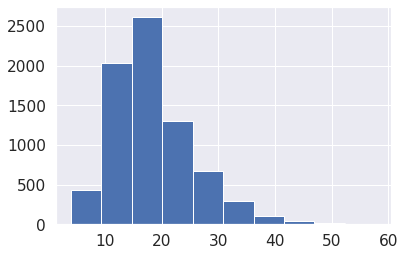

In [222]:
df_train.Years_of_Credit_History.hist()

<AxesSubplot:>

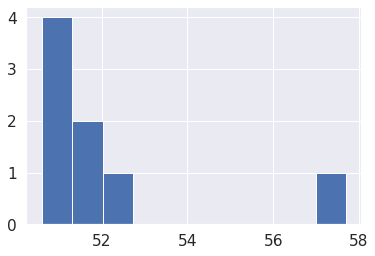

In [223]:
df_train.Years_of_Credit_History[df_train.Years_of_Credit_History > 50].hist()

Все ровно.

**Current_Credit_Balance**

<AxesSubplot:>

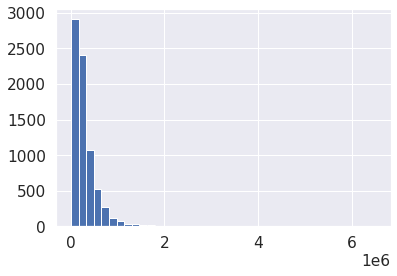

In [224]:
df_train.Current_Credit_Balance.hist(bins=40)

<AxesSubplot:>

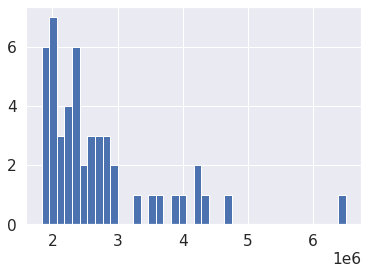

In [225]:
df_train.Current_Credit_Balance[df_train.Current_Credit_Balance > 1800000].hist(bins=40)

Аномалий нет.

**Maximum_Open_Credit**

<AxesSubplot:>

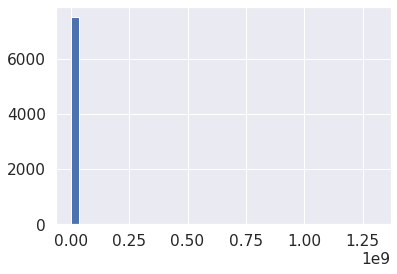

In [226]:
df_train.Maximum_Open_Credit.hist(bins=40)

<AxesSubplot:>

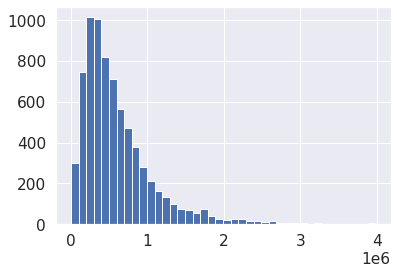

In [227]:
df_train.Maximum_Open_Credit[df_train.Maximum_Open_Credit < 4000000].hist(bins=40)

In [228]:
df_train.Maximum_Open_Credit[df_train.Maximum_Open_Credit > 3000000].value_counts()

8706038.0     1
8903180.0     1
5784482.0     1
4309294.0     1
3007136.0     1
             ..
57562560.0    1
3507042.0     1
6658762.0     1
4767444.0     1
5879808.0     1
Name: Maximum_Open_Credit, Length: 98, dtype: int64

Нормально все.

**Bankruptcies**

In [229]:
df_train.Bankruptcies.value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

Можно ограничить кол-во банкротств пятью.

In [230]:
df_train.loc[df_train.Bankruptcies > 5, 'Bankruptcies'] = 1

Здесь 0,2% Нанов. Признак почти не коррелирует с таргетом, поэтому не буду заморачиваться с длинным кодом, заменю на нули.

In [231]:
df_train.Bankruptcies = df_train.Bankruptcies.fillna(20)

In [232]:
for idx, row in df_train.iterrows():
    if row.Bankruptcies == 20:
        df_train.loc[idx, 'Bankruptcies'] = 0

**Months_since_last_delinquent**

<AxesSubplot:>

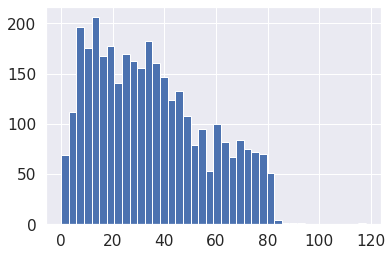

In [233]:
df_train.Months_since_last_delinquent.hist(bins=40)

In [234]:
df_train.Months_since_last_delinquent[df_train.Months_since_last_delinquent > 80].value_counts()

81.0     19
82.0      4
83.0      3
92.0      1
91.0      1
84.0      1
118.0     1
86.0      1
Name: Months_since_last_delinquent, dtype: int64

OK.

## 6. **Обработка Nan**  <a class='anchor' id='eda'>

**Months_since_last_delinquent**

In [235]:
df_train['Months_since_last_delinquent_nan'] = 0
df_train.loc[df_train.Months_since_last_delinquent.isna(), 'Months_since_last_delinquent_nan'] = 1

<AxesSubplot:>

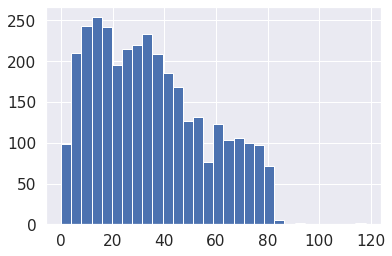

In [236]:
df_train.Months_since_last_delinquent.hist(bins=30)

In [237]:
df_train[df_train.Months_since_last_delinquent_nan == 0].Credit_Default.value_counts()

0    2436
1     983
Name: Credit_Default, dtype: int64

In [238]:
df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Credit_Default.value_counts()

0    12
1     6
Name: Credit_Default, dtype: int64

In [239]:
df_train[df_train.Months_since_last_delinquent_nan == 1].Number_of_Credit_Problems.value_counts()

0.0    3557
1.0     468
2.0      38
3.0      15
4.0       3
Name: Number_of_Credit_Problems, dtype: int64

In [240]:
df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Number_of_Credit_Problems.value_counts()

0.0    18
Name: Number_of_Credit_Problems, dtype: int64

In [241]:
df_train[df_train.Months_since_last_delinquent_nan == 1].Bankruptcies.value_counts()

0.0    3621
1.0     441
2.0      15
3.0       3
4.0       1
Name: Bankruptcies, dtype: int64

In [242]:
df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Bankruptcies.value_counts()

0.0    18
Name: Bankruptcies, dtype: int64

<AxesSubplot:>

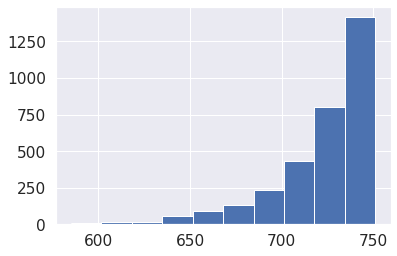

In [243]:
df_train[df_train.Months_since_last_delinquent_nan == 1].Credit_Score.hist()

<AxesSubplot:>

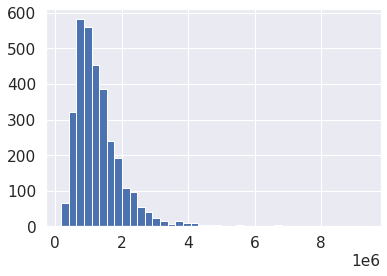

In [244]:
df_train[df_train.Months_since_last_delinquent_nan == 1].Annual_Income.hist(bins=40)

In [245]:
Z=df_train[['Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History', 
          'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Bankruptcies', 
          'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Default'
          ]][df_train.Months_since_last_delinquent_nan==0]

In [246]:
w=df_train['Months_since_last_delinquent'][df_train.Months_since_last_delinquent_nan==0]
Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)

*GradientBoostingRegressor*

In [247]:
gb_model = GradientBoostingRegressor(criterion='mse',
                          min_samples_leaf=10,
                          random_state=42,
                          n_estimators=100,
                          max_depth=7
                         )
gb_model.fit(Z_train, w_train)

GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)

In [248]:
%%time
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth':[3, 5, 7, 10],
          'min_samples_leaf': [3, 5, 7, 10],
          'max_features': np.arange(5, 10)}

gs = GridSearchCV(gb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=21, 
                           shuffle=True),
                  n_jobs=-1
                  )
gs.fit(Z_train, w_train)

CPU times: user 6.32 s, sys: 479 ms, total: 6.8 s
Wall time: 17min 42s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=7,
                                                 min_samples_leaf=10,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_features': array([5, 6, 7, 8, 9]),
                         'min_samples_leaf': [3, 5, 7, 10],
                         'n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [249]:
gs.best_score_

0.019328096718371213

In [250]:
gs.best_params_

{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 3, 'n_estimators': 50}

In [251]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=3,
                                        max_features=5,
                                        min_samples_leaf=7,
                                        random_state=42,  
                                        n_estimators=50)
final_model.fit(Z_train, w_train)

GradientBoostingRegressor(criterion='mse', max_features=5, min_samples_leaf=7,
                          n_estimators=50, random_state=42)

Train R2:	0.113
Test R2:	0.043


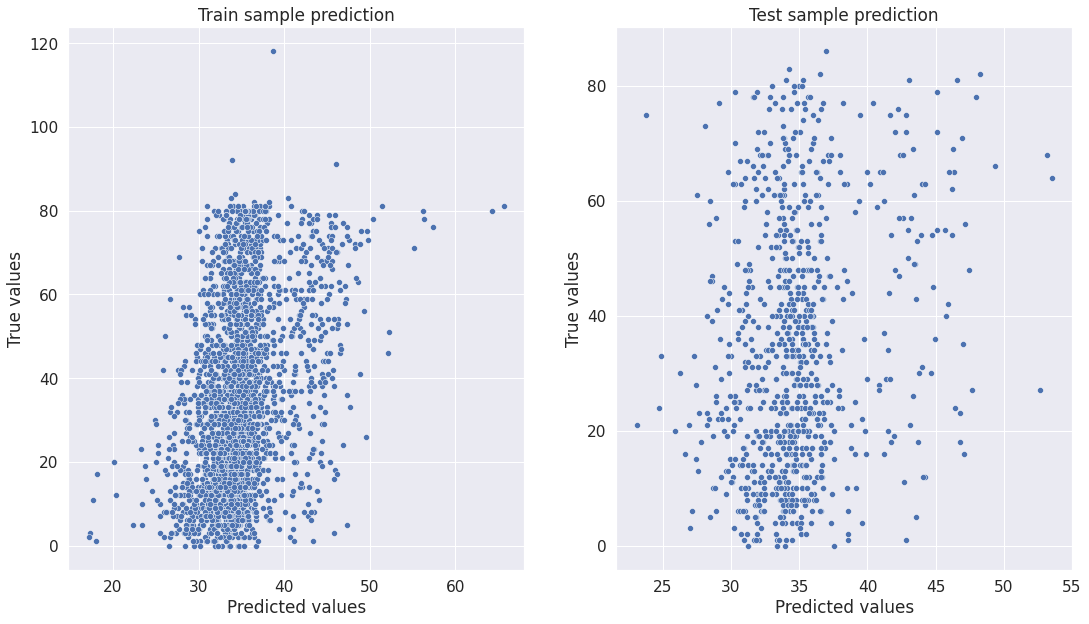

In [252]:
w_train_preds = final_model.predict(Z_train)
w_test_preds = final_model.predict(Z_test)
evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

*XGBRegressor*

In [253]:
gs = GridSearchCV(
            estimator=xgb.XGBRegressor(),
            param_grid={"learning_rate": (0.05, 0.10, 0.15),
                        "max_depth": [ 3, 4, 5, 6, 8],
                        "min_child_weight": [ 1, 3, 5, 7],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[ 0.3, 0.4],},
            cv=3, scoring='r2', verbose=0, n_jobs=-1)

gs.fit(Z_train, w_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [254]:
gs.best_params_

{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.05,
 'max_depth': 3,
 'min_child_weight': 5}

In [255]:
gs.best_score_

0.014395062323671048

Модели дали близкую к 0 метрику. Признак линейно ни с кем не коррелирует. Но ввиду того что очень мало нулевых значений, можно предположить, что наны просто не заполнили нулями. Поэтому сохраню этот признак в отдельный датафрейм с нулями вместо нанов а потом проверю как он влияет на точность модели.

In [256]:
df_train.Months_since_last_delinquent=df_train.Months_since_last_delinquent.fillna(0)

**Annual_Income**

Модели не дали хорошую метрику качества.

In [257]:
df_train.Annual_Income=df_train.Annual_Income.fillna(0)

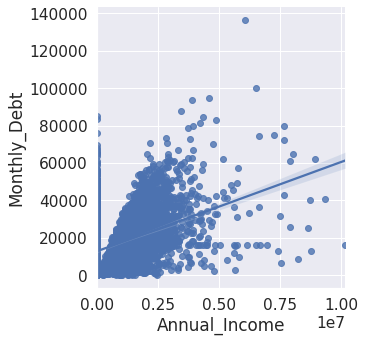

In [258]:
sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 14000000)])

In [259]:
list1 = list(range(1,100000,100))
for i in range(len(list1)-1):
  mdn=df_train.Annual_Income[(df_train.Monthly_Debt >= list1[i-1]) & (df_train.Monthly_Debt < list1[i]) & (df_train.Annual_Income > \
                                                                              5) & (df_train.Annual_Income <= 7000000)].median()
  df_train.loc[(df_train.Monthly_Debt >= list1[i-1]) & (df_train.Monthly_Debt < list1[i]) & (df_train.Annual_Income  == 0), \
               'Annual_Income'] = mdn

In [260]:
df_train.Annual_Income=df_train.Annual_Income.fillna(df_train.Annual_Income.median()) 

*Credit_Score*

Credit_Score ни с кем не коррелирует, заменю предварительно Наны на медиану

In [261]:
df_train['Credit_Score_nan'] = 0
df_train.loc[df_train.Credit_Score.isna(), 'Credit_Score_nan'] = 1

*Current_Loan_Amount*

In [262]:
df_train['Current_Loan_Amount_nan'] = 0
df_train.loc[df_train.Current_Loan_Amount.isna(), 'Current_Loan_Amount_nan'] = 1

Модели не помогли.

In [263]:
df_train.loc[df_train.Current_Loan_Amount_nan == 1, 'Current_Loan_Amount'] = 0

In [264]:
df_train.Current_Loan_Amount.isna().sum()

0

Здесь корреляции почти не видно. Признак хорошо коррелирует с таргетом. Попробую через таргет энкодинг сгенерировать признак для обработки нанов.

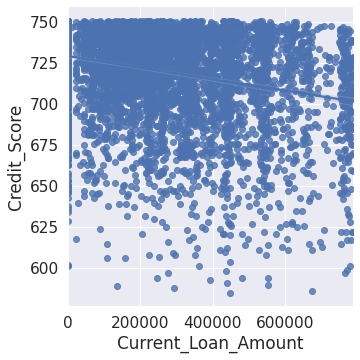

In [265]:
sns.lmplot(x='Current_Loan_Amount', y='Credit_Score', data=df_train[(df_train.Credit_Score < 100000) & (df_train.Current_Loan_Amount< 10000000)])

In [266]:
df_test[(df_test.Credit_Score == np.nan) & (df_test.Current_Loan_Amount == 0)]

Empty DataFrame
Columns: [Home_Ownership, Annual_Income, Tax_Liens, Number_of_Open_Accounts, Years_of_Credit_History, Maximum_Open_Credit, Number_of_Credit_Problems, Months_since_last_delinquent, Bankruptcies, Purpose, Term, Current_Loan_Amount, Current_Credit_Balance, Monthly_Debt, Credit_Score]
Index: []

In [267]:
df_train.Credit_Score.value_counts()

740.0    184
747.0    172
748.0    163
741.0    155
745.0    155
        ... 
609.0      1
598.0      1
641.0      1
589.0      1
620.0      1
Name: Credit_Score, Length: 160, dtype: int64

## 8. **Масштабрование данных**  <a class='anchor' id='eda'>

In [268]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

In [269]:
df_norm.head()

Home_Ownership  Annual_Income  Tax_Liens  Number_of_Open_Accounts  \
0       Own_Rent      -1.084402  -0.110953                -0.026674   
1       Own_Rent      -0.394730  -0.110953                 0.788223   
2       Mortgage      -0.742580  -0.110953                -0.026674   
3       Own_Rent      -0.674481  -0.110953                -0.637847   
4       Own_Rent      -0.711038  -0.110953                 0.380774   

   Years_of_Credit_History  Maximum_Open_Credit  Number_of_Credit_Problems  \
0                 1.133645            -0.016174                   1.664779   
1                -0.428528             0.014763                  -0.340979   
2                 2.369181             0.014807                  -0.340979   
3                 0.593985            -0.049781                   1.664779   
4                -0.669954            -0.034902                   1.664779   

   Months_since_last_delinquent  Bankruptcies     Purpose        Term  \
0                     -0.698307      2.545732  game_other  Short Term   
1                     -0.698307     -0.337099  game_other   Long Term   
2                     -0.698307     -0.337099  game_other  Short Term   
3                     -0.698307      2.545732  game_other  Short Term   
4                     -0.698307     -0.337099  game_other  Short Term   

   Current_Loan_Amount  Current_Credit_Balance  Monthly_Debt  Credit_Score  \
0            -1.380382               -0.762772     -0.887802      1.034274   
1            -0.041483                0.330781      0.023295      0.605011   
2            -1.380382                0.058379     -0.388044      0.783871   
3            -0.766961               -0.610282     -0.589533     -0.933182   
4            -0.744505               -0.618292     -0.951741     -0.038884   

   Credit_Default  Id  Months_since_last_delinquent_nan  Credit_Score_nan  \
0               0   0                                 1                 0   
1               1   1                                 1                 0   
2               0   2                                 1                 0   
3               0   3                                 1                 0   
4               0   4                                 1                 0   

   Current_Loan_Amount_nan  
0                        1  
1                        0  
2                        1  
3                        0  
4                        0

**Сохранение модели для масштабирования данных**

In [270]:
#with open('scaler.pkl', 'wb') as file:
#    pickle.dump(scaler, file)

## 7. **КОРРЕЛЯЦИЯ**  <a class='anchor' id='eda'>

Построю корреляцию по таргету на стандартизованных признаках.

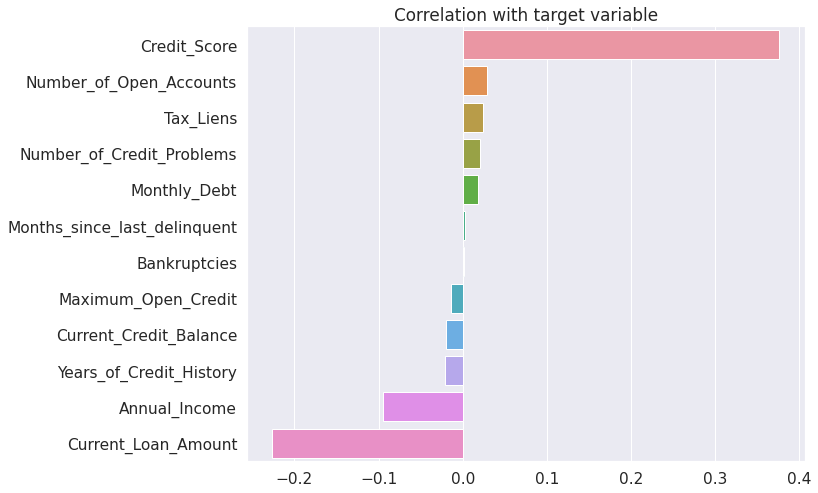

In [271]:
corr_with_target = df_train_med[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

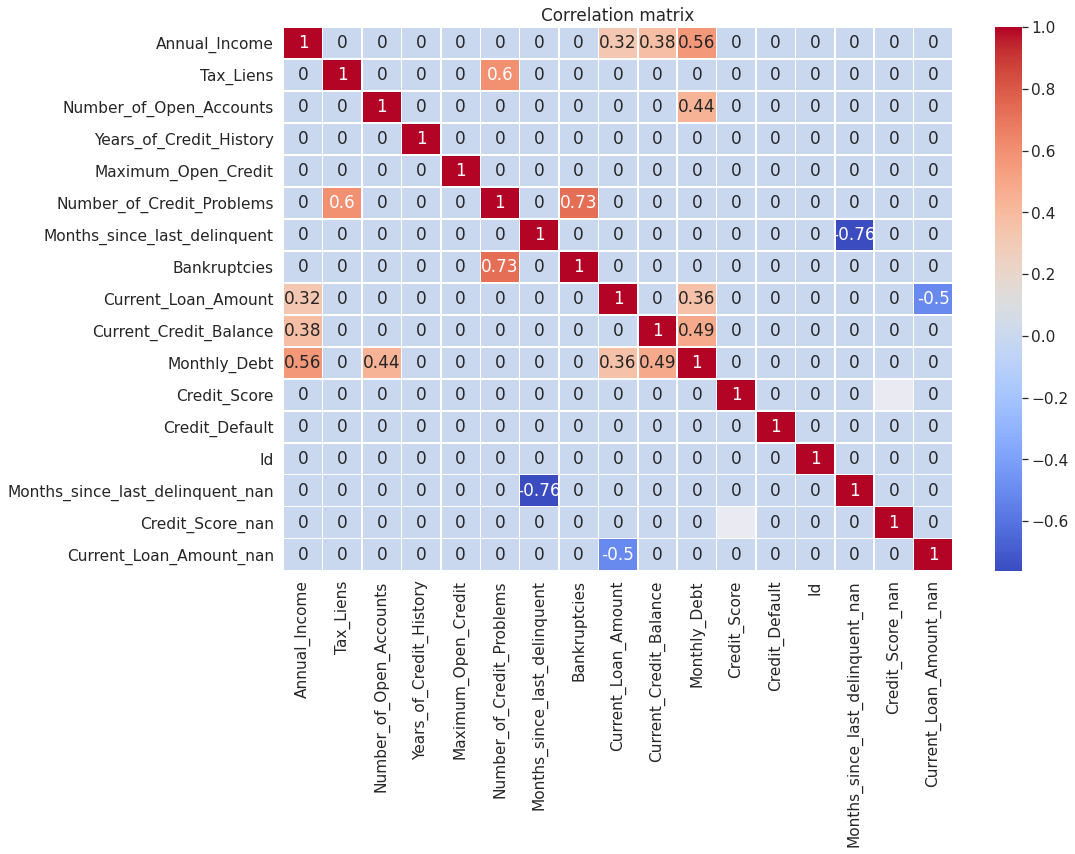

In [272]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_norm.corr()
corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # если корреляция меньше 0,3, то мы заменим на 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [273]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [274]:
df_train=df_train.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score', 'Credit Default': 'Credit_Default'})

In [275]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [276]:
df_test=df_test.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score'})

In [277]:
df_train=change_Purpose(df_train)
df_test=change_Purpose(df_test)

In [278]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit_Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit_Default, dtype: float64

## 1. **DATAPREPROCESSING**  <a class='anchor' id='eda'>

In [279]:
def imputer_rfr(data, target_col):
    #для воспроизведения недостающих значений на тестовых данных с обучением

    data[target_col + '_nan'] = 0
    data.loc[data[target_col].isna(), target_col + '_nan'] = 1
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=7,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [280]:
def imputer_rfr_test(data, target_col, model):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    #train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return data

In [281]:
#Уменьшил до 0,1 переобучение
#for idx, row in X_train.iterrows():
#    if (row.Credit_Score > 1000):
 #       X_train.loc[idx, 'Credit_Score'] = row.Credit_Score/10
#for idx, row in X_test.iterrows():
 #   if (row.Credit_Score > 1000):
  #      X_test.loc[idx, 'Credit_Score'] = row.Credit_Score/10

In [282]:
#создал самую важную для обучения функцию
#X_train['Current_Loan_Amount_over'] = 0
#X_test['Current_Loan_Amount_over'] = 0
#X_train.loc[X_train.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1
#X_test.loc[X_test.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1

In [283]:
#X_train.loc[X_train.Bankruptcies > 5, 'Bankruptcies'] = 1

In [284]:
#признаки для определения недостающих значений
#def finder_nan(data, target_col):
 #   #data = data.copy()
#    data[target_col + '_nan'] = 0
 #   data.loc[data[target_col].isna(), target_col + '_nan'] = 1

#finder_nan(X_train, 'Annual_Income')
#finder_nan(X_test, 'Annual_Income')
#finder_nan(X_train, 'Years_in_current_job')
#finder_nan(X_test, 'Years_in_current_job')
#finder_nan(X_train, 'Months_since_last_delinquent')
#finder_nan(X_test, 'Months_since_last_delinquent')
#finder_nan(X_train, 'Bankruptcies')
#finder_nan(X_test, 'Bankruptcies')
#finder_nan(X_train, 'Credit_Score')
#finder_nan(X_test, 'Credit_Score')

In [285]:
#Предварительно обработаю Наны
#X_train.Months_since_last_delinquent=X_train.Months_since_last_delinquent.fillna(0)
#X_test.Months_since_last_delinquent=X_test.Months_since_last_delinquent.fillna(0)
#X_train.Annual_Income.fillna(X_train.Annual_Income.median(), inplace=True)
#X_test.Annual_Income.fillna(X_train.Annual_Income.median(), inplace=True)
#X_train.Credit_Score.fillna(X_train.Credit_Score.median(), inplace=True)
#X_test.Credit_Score.fillna(X_train.Credit_Score.median(), inplace=True)
#X_train.Years_in_current_job.fillna('10+ years', inplace=True)
#X_test.Years_in_current_job.fillna('10+ years', inplace=True)

In [286]:
#обработка категориальных признаков
#X_train['Years_in_current_job'] = X_train['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
#X_test['Years_in_current_job'] = X_test['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
#X_train.Years_in_current_job=X_train.Years_in_current_job.astype(dtype='int32')
#X_test.Years_in_current_job=X_test.Years_in_current_job.astype(dtype='int32')
#X_train.loc[X_train.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
#X_test.loc[X_test.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
#X_train.loc[X_train.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
#X_test.loc[X_test.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
#X_train.loc[X_train.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
#X_test.loc[X_test.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
#X_train.loc[X_train.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3
#X_test.loc[X_test.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3
#X_train.loc[X_train.Purpose == 'educational_debt', 'Purpose'] = 0
#X_test.loc[X_test.Purpose == 'educational_debt', 'Purpose'] = 0
#X_train.loc[X_train.Purpose == 'other_major', 'Purpose'] = 1
#X_test.loc[X_test.Purpose == 'other_major', 'Purpose'] = 1
#X_train.loc[X_train.Purpose == 'business_small', 'Purpose'] = 2
#X_test.loc[X_test.Purpose == 'business_small', 'Purpose'] = 2
#X_train.loc[X_train.Purpose == 'renewable energy', 'Purpose'] = 3
#X_test.loc[X_test.Purpose == 'renewable energy', 'Purpose'] = 3
#X_train.loc[X_train.Term == 'Short Term', 'Term'] = 0
#X_test.loc[X_test.Term == 'Short Term', 'Term'] = 0
#X_train.loc[X_train.Term == 'Long Term', 'Term'] = 1
#X_test.loc[X_test.Term == 'Long Term', 'Term'] = 1


Перевел вышеуказанный код в класс DataPreprocessing

In [287]:
class DataPreprocessing:
    
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):     
        # Расчет медиан
        self.medians = X.median()
  
    def transform(self, X):
        """Убираем выбросы"""
        X.loc[X.Annual_Income < 140000, 'Annual_Income'] = np.nan
        """Исправление аномалии в признаках"""
        for idx, row in X.iterrows():
            if (row.Credit_Score > 1000):
                X.loc[idx, 'Credit_Score'] = row.Credit_Score/10
                
        X['Current_Loan_Amount_over'] = 0
        X.loc[X.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1
        
        X.loc[X.Bankruptcies > 5, 'Bankruptcies'] = 1
        
        """Создание признаков для Nan"""
        self.finder_nan(X, 'Annual_Income')
        self.finder_nan(X, 'Years_in_current_job')
        self.finder_nan(X, 'Months_since_last_delinquent')
        self.finder_nan(X, 'Bankruptcies')
        self.finder_nan(X, 'Credit_Score')
        
        """Предварительная обработка Нанов, заполние их медианными значениями
"""
        X.Months_since_last_delinquent=X.Months_since_last_delinquent.fillna(0)
        X.Years_in_current_job.fillna('10+ years', inplace=True)
        X.fillna(self.medians, inplace=True)
        
        """Обработка категориальных признаков"""
        X['Years_in_current_job'] = X['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
        X.Years_in_current_job=X.Years_in_current_job.astype(dtype='int32')
        
        X.loc[X.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
        X.loc[X.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
        X.loc[X.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
        X.loc[X.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3

        X.loc[X.Purpose == 'educational_debt', 'Purpose'] = 0
        X.loc[X.Purpose == 'other_major', 'Purpose'] = 1
        X.loc[X.Purpose == 'business_small', 'Purpose'] = 2
        X.loc[X.Purpose == 'renewable energy', 'Purpose'] = 3
        
        X.loc[X.Term == 'Short Term', 'Term'] = 0
        X.loc[X.Term == 'Long Term', 'Term'] = 1
        
        return X
        
    
    def finder_nan(self, X, target_col):
        X[target_col + '_nan'] = 0
        X.loc[X[target_col].isna(), target_col + '_nan'] = 1
        return X

In [288]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

Окончательная обработка недостающих значений. Функции сложные, с поиском лучших параметров, поэтому не стал выносить их в общий класс.

Bankruptcies

Следующий код не изменил метрики на Катбусте, но точность у модели высокая. 

In [289]:
X_train.loc[X_train.Bankruptcies_nan == 1, 'Bankruptcies'] = np.nan
feature_name = 'Bankruptcies'
Bankruptcies_predictor, X_train = imputer_rfr(X_train, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9001257419332971
r2 на test: 0.742296379954577


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [290]:
X_test.loc[X_test.Bankruptcies_nan == 1, 'Bankruptcies'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Bankruptcies_predictor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [291]:
X_train.Bankruptcies=X_train.Bankruptcies.astype(np.int)
X_test.Bankruptcies=X_test.Bankruptcies.astype(np.int)

Annual_Income

In [292]:
def imputer_rfr_Annual_Income(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
        
    model = RandomForestRegressor(n_estimators=30,
                             max_depth=3,
                             min_samples_leaf=7,
                             min_samples_split=3,
                             random_state=42,
                             verbose=1)
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    #parametrs = { 'n_estimators': range (10, 51, 10),
     #             'max_depth': [2, 3, 4, 5],
      #            'min_samples_leaf': [5, 6, 7, 8, 9],
       #           'min_samples_split': [3, 5, 7, 9] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [293]:
X_train.loc[X_train.Annual_Income_nan == 1, 'Annual_Income'] = np.nan
feature_name = 'Annual_Income'
Annual_Income_predictor, X_train = imputer_rfr_Annual_Income(X_train, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


r2 на train: 0.4144249301876113
r2 на test: 0.4068101100384822


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [294]:
#gs_best_params

In [295]:
X_test.loc[X_test.Annual_Income_nan == 1, 'Annual_Income'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Annual_Income_predictor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


Current_Loan_Amount

In [296]:
def imputer_rfr_Current_Loan_Amount(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=500,
            learning_rate=0.03,
            l2_leaf_reg=8
            )

    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    parametrs = {'iterations': [300, 400, 500],
              'depth': [3, 4, 5],
              'learning_rate': [0.03, 0.3, 0.5],
              'l2_leaf_reg': [3, 4, 5, 6, 7, 8] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [297]:
X_train.loc[X_train.Current_Loan_Amount_over == 1, 'Current_Loan_Amount'] = np.nan
feature_name = 'Current_Loan_Amount'
Current_Loan_Amount_predictor, X_train = imputer_rfr_Current_Loan_Amount(X_train, feature_name)

r2 на train: 0.5911353492398608
r2 на test: 0.5200504081306092


In [298]:
#gs_best_params

In [299]:
X_test.loc[X_test.Current_Loan_Amount_over == 1, 'Current_Loan_Amount'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Current_Loan_Amount_predictor)

Credit_Score

In [300]:
def imputer_rfr_Credit_Score(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

        
    model = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=500,
            learning_rate=0.03,
            l2_leaf_reg=8
            )

    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    parametrs = {'iterations': [300, 400, 500],
              'depth': [3, 4, 5],
              'learning_rate': [0.03, 0.3, 0.5],
              'l2_leaf_reg': [3, 4, 5, 6, 7, 8] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [301]:
X_train.loc[X_train.Credit_Score_nan == 1, 'Credit_Score'] = np.nan
feature_name = 'Credit_Score'
Credit_Score_predictor, X_train = imputer_rfr_Credit_Score(X_train, feature_name)

r2 на train: 0.4351818131764762
r2 на test: 0.34858731744145643


In [302]:
X_test.loc[X_test.Credit_Score_nan == 1, 'Credit_Score'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Credit_Score_predictor)

# ГЕНЕРАЦИЯ НОВЫХ ПРИЗНАКОВ

Генерация новых признаков ухудшила метрику, либо не дала результата

# Балансировка данных

In [303]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

1    3771
0    3771
Name: Credit_Default, dtype: int64

In [304]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [305]:
X_train_balanced.Home_Ownership=X_train_balanced.Home_Ownership.astype('int32')
X_test.Home_Ownership=X_test.Home_Ownership.astype('int32')
X_train.Home_Ownership=X_train.Home_Ownership.astype('int32')
X_train_balanced.Purpose=X_train_balanced.Purpose.astype('int32')
X_test.Purpose=X_test.Purpose.astype('int32')
X_train.Purpose=X_train.Purpose.astype('int32')
X_train_balanced.Term=X_train_balanced.Term.astype('int32')
X_test.Term=X_test.Term.astype('int32')
X_train.Term=X_train.Term.astype('int32')

XGBoost

In [306]:
#model_xgb = xgb.XGBClassifier(random_state=21, 
 #                             max_depth=2, 
  #                            )
#model_xgb.fit(X_train_balanced, y_train_balanced)

#evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

In [307]:
#param_dist = {"max_depth": [10,30,50],
 #             "min_child_weight" : [1,3,6],
  #            "n_estimators": [50, 100, 200],
   #           "learning_rate": [0.05, 0.1,0.16],}
#grid_search = GridSearchCV(model_xgb, param_grid=param_dist, cv = 3, 
 #                                  verbose=10, n_jobs=-1)
#grid_search.fit(X_train_balanced, y_train_balanced)

#grid_search.best_estimator_

In [308]:
#cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [309]:
#%%time
#grid_search = GridSearchCV(param_grid=param_dist, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
#grid_search.fit(X_train_balanced, y_train_balanced)
#display(grid_search.best_params_, grid_search.best_score_)

In [310]:
#best_model_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 #             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
  #            importance_type='gain',
   #           learning_rate=0.1, max_delta_step=0, max_depth=10,
    #          min_child_weight=1,
     #         n_estimators=200, n_jobs=2, num_parallel_tree=1, random_state=21,
      #        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       #       tree_method='exact', validate_parameters=1)
#best_model_xgb.fit(X_train_balanced, y_train_balanced)

#evaluate_preds(best_model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

LightGBM

In [311]:
#%%time
#model_lgbm = lgbm.LGBMClassifier(random_state=21, 
 #                                 class_weight={0:1, 1:2.55},
  #                                n_estimators=50
   #                             )
#model_lgbm.fit(X_train, y_train)

#evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

In [312]:
#param_dist = {"max_depth": [25,50, 75],
 #             "learning_rate" : [0.01,0.05,0.1],
  #            "num_leaves": [300,900,1200],
   #           "n_estimators": [50, 100]
    #         }
#grid_search = GridSearchCV(model_lgbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="f1", verbose=5)
#grid_search.fit(X_train, y_train)
#grid_search.best_estimator_

In [313]:
#best_model_lgbm = lgbm.LGBMClassifier(random_state=21, 
 #                                 class_weight={0:1, 1:2.55},
  #                                n_estimators=50,
   #                               num_leaves=300,
    #                              learning_rate=0.01,
     #                             max_depth=2
      #                          )

#best_model_lgbm.fit(X_train, y_train)

In [314]:
#evaluate_preds(best_model_lgbm, X_train, X_test, y_train, y_test)

Catboost

Лучший результат показал Катбуст

In [315]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [316]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': ['Home_Ownership', 'Years_in_current_job', 
                      'Purpose', 'Term', 'Current_Loan_Amount_over', 'Annual_Income_nan',
                      'Credit_Score_nan'],
     'eval_metric':'F1',
     'early_stopping_rounds':40
}

In [317]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.39      0.54      3771
           1       0.36      0.87      0.51      1479

    accuracy                           0.52      5250
   macro avg       0.62      0.63      0.52      5250
weighted avg       0.74      0.52      0.53      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      1616
           1       0.36      0.86      0.51       634

    accuracy                           0.53      2250
   macro avg       0.62      0.63      0.53      2250
weighted avg       0.73      0.53      0.53      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               640  976
1                90  544
CPU times: user 816 ms, sys: 123 ms, total: 939 ms
Wall time: 784 ms


In [318]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

feature_name  importance
16          Current_Loan_Amount_over   95.017041
15                      Credit_Score    4.680847
12               Current_Loan_Amount    0.298303
9                       Bankruptcies    0.003808
0                     Home_Ownership    0.000000
20                  Bankruptcies_nan    0.000000
19  Months_since_last_delinquent_nan    0.000000
18          Years_in_current_job_nan    0.000000
17                 Annual_Income_nan    0.000000
14                      Monthly_Debt    0.000000
13            Current_Credit_Balance    0.000000
11                              Term    0.000000
1                      Annual_Income    0.000000
10                           Purpose    0.000000
8       Months_since_last_delinquent    0.000000
7          Number_of_Credit_Problems    0.000000
6                Maximum_Open_Credit    0.000000
5            Years_of_Credit_History    0.000000
4            Number_of_Open_Accounts    0.000000
3                          Tax_Liens    0.000000
2               Years_in_current_job    0.000000
21                  Credit_Score_nan    0.000000

Попытка снижения степени переобучения

In [319]:
%%time
model_catb = catb.CatBoostClassifier(class_weights=[1,2.54], silent=True, random_state=21)
params = {'iterations':[50, 100, 200],
          'depth':[3, 5, 8],
          'learning_rate' : [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

CPU times: user 520 ms, sys: 40.7 ms, total: 561 ms
Wall time: 16.8 s


{'learning_rate': 0.15, 'l2_leaf_reg': 9, 'iterations': 50, 'depth': 5}

In [320]:
rs.best_score_

0.5211113373934856

In [321]:
best_model_catb = catb.CatBoostClassifier(class_weights=[1,2.54], 
                                          silent=True, 
                                          random_state=21,
                                          learning_rate=0.15, 
                                          l2_leaf_reg=9, 
                                          iterations=50, 
                                          depth=3
                                         )

In [322]:
best_model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(best_model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.60      0.71      3771
           1       0.42      0.75      0.54      1479

    accuracy                           0.64      5250
   macro avg       0.64      0.68      0.63      5250
weighted avg       0.74      0.64      0.66      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.58      0.68      1616
           1       0.39      0.69      0.50       634

    accuracy                           0.61      2250
   macro avg       0.61      0.64      0.59      2250
weighted avg       0.70      0.61      0.63      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               945  671
1               199  435


In [323]:
y_train_proba=predict_proba_compare(best_model_catb, X_test, X_train, y_test, y_train, 0.4)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.38      0.53      3771
           1       0.37      0.92      0.52      1479

    accuracy                           0.53      5250
   macro avg       0.64      0.65      0.53      5250
weighted avg       0.77      0.53      0.53      5250

TEST

              precision    recall  f1-score   support

           0       0.89      0.37      0.52      1616
           1       0.35      0.88      0.50       634

    accuracy                           0.51      2250
   macro avg       0.62      0.62      0.51      2250
weighted avg       0.74      0.51      0.52      2250

CONFUSION MATRIX

col_0             0     1
Credit_Default           
0               595  1021
1                75   559


In [324]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [325]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5)

In [326]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [327]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6580100085
bestIteration = 91

0:	loss: 0.6580100	best: 0.6580100 (0)	total: 1.42s	remaining: 1m 9s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6685402232
bestIteration = 28

1:	loss: 0.6685402	best: 0.6685402 (1)	total: 2.06s	remaining: 49.6s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6642960677
bestIteration = 113

2:	loss: 0.6642961	best: 0.6685402 (1)	total: 3.52s	remaining: 55.1s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6612250495
bestIteration = 97

3:	loss: 0.6612250	best: 0.6685402 (1)	total: 4.81s	remaining: 55.3s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6643480304
bestIteration = 107

4:	loss: 0.6643480	best: 0.6685402 (1)	total: 6.17s	remaining: 55.5s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6714517314
bestIteration = 127

5:	loss: 0.6714517	best: 0.6714517 (5)	total: 7.71s	remain

Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.6673828084
bestIteration = 21

49:	loss: 0.6673828	best: 0.6730864 (21)	total: 53.1s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (40 iterations wait)


In [328]:
cv_results = pd.DataFrame(grid_search["cv_results"])

In [329]:
grid_search.get('params')

{'l2_leaf_reg': 1.9265822784810127}

In [330]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5,
                                l2_leaf_reg=2)
model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [331]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.39      0.54      3771
           1       0.36      0.87      0.51      1479

    accuracy                           0.52      5250
   macro avg       0.62      0.63      0.52      5250
weighted avg       0.74      0.52      0.53      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.40      0.55      1616
           1       0.36      0.86      0.51       634

    accuracy                           0.53      2250
   macro avg       0.62      0.63      0.53      2250
weighted avg       0.73      0.53      0.53      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               640  976
1                90  544
CPU times: user 74.3 ms, sys: 208 µs, total: 74.5 ms
Wall time: 75.4 ms


Выбор порога вероятности для определения класса

In [332]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (12, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()


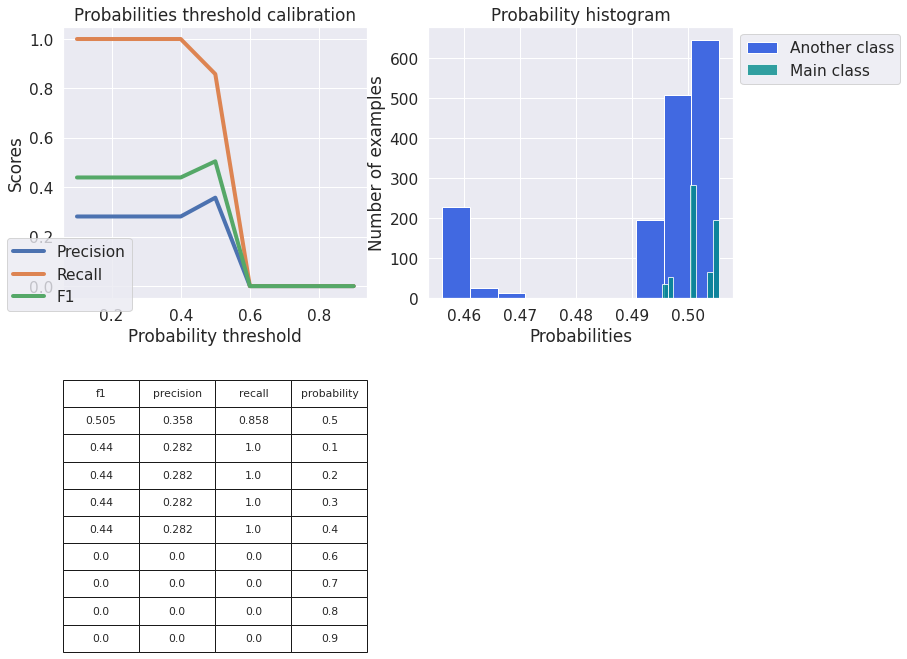

In [333]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Говорит что оптимальный порог вероятности 0,5

Создал функцию для изменения результирующей выборки в зависимости от порога вероятности

In [336]:
y_train_proba=predict_proba_compare(model, X_test, X_train, y_test, y_train, 0.51)

TRAIN

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      3771
           1       1.00      0.00      0.00      1479

    accuracy                           0.72      5250
   macro avg       0.86      0.50      0.42      5250
weighted avg       0.80      0.72      0.60      5250

TEST

              precision    recall  f1-score   support

           0       0.72      1.00      0.84      1616
           1       0.00      0.00      0.00       634

    accuracy                           0.72      2250
   macro avg       0.36      0.50      0.42      2250
weighted avg       0.52      0.72      0.60      2250

CONFUSION MATRIX

col_0              0
Credit_Default      
0               1616
1                634


Хочу целевую метрику f1-score по нулю!)))

Кривая обучения

In [334]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

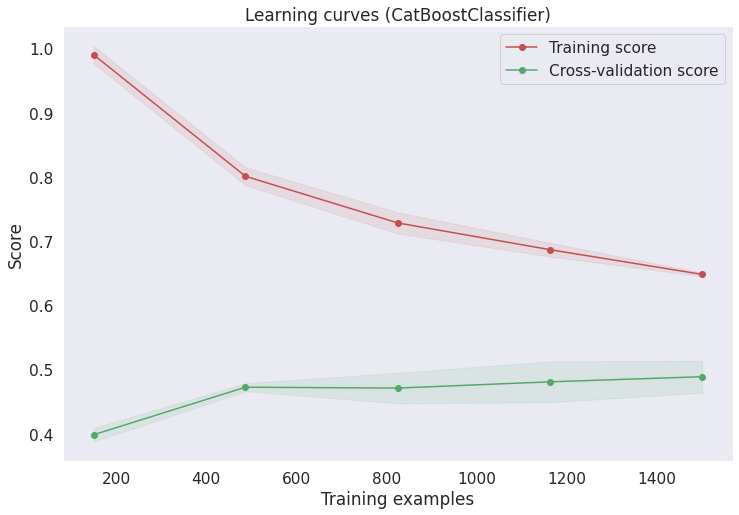

In [335]:
show_learning_curve_plot(model, X_test, y_test)

У первоначальной модели переобучение нулевое, поэтому все "улучшайзеры" не помогают.